In [2]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, output_notebook

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import display

In [2]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

In [3]:
if (False):
    sql = """select * 
    from mimiciii.icu_features
    """
    df = pd.read_sql_query(sql, conn)
    df.to_pickle("icu_features.pkl")

In [4]:
df =pd.read_pickle('icu_features.pkl')
#df = pd.read_csv('icu_features.csv')  # -- from Grace

In [5]:
df.shape

(61532, 152)

In [6]:
df.columns.tolist()

['icustay_id',
 'hadm_id',
 'subject_id',
 'age',
 'gender',
 'height',
 'weight',
 'ethnicity',
 'insurance',
 'filter_vaso',
 'filter_chronic_dialysis',
 'filter_angus_sepsis',
 'filter_hard_cardiogenic',
 'filter_adult',
 'filter_echo',
 'ed_chartdate',
 'ed_charttime',
 'ed_quality',
 'ed_indication',
 'ed_bsa',
 'ed_bp',
 'ed_bpsys',
 'ed_bpdias',
 'ed_hr',
 'ed_test',
 'ed_doppler',
 'ed_contrast',
 'ea_hadm_id',
 'ea_new_time',
 'ea_key',
 'ea_height',
 'ea_weight',
 'ea_sys',
 'ea_diastolic',
 'ea_hr',
 'ea_tv_pulm_htn',
 'ea_tv_regurgitation',
 'ea_tv_stenosis',
 'ea_lv_cavity',
 'ea_lv_diastolic',
 'ea_lv_systolic',
 'ea_lv_wall',
 'ea_rv_cavity',
 'ea_rv_volume_overload',
 'ea_rv_systolic',
 'ea_rv_wall',
 'ea_av_regurgitation',
 'ea_av_stenosis',
 'ea_mv_regurgitation',
 'ea_mv_stenosis',
 'ea_la_cavity',
 'ea_ra_dilated',
 'ea_ra_pressure',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascu

# calculate some new features

In [27]:
#day30_mortality = df.ea_days_after_discharge_death <= 30
day30_mortality = (df.dod - df.intime) < np.timedelta64(30, 'D')
df['day30_mortality'] = day30_mortality

delta_creat = df.creatinine_last - df.creatinine_max;
df['delta_creat']  = delta_creat

delta_lactate = df.lactate_last - df.lactate_max;
df['delta_lactate']  = delta_lactate

had_echo = ~df['ea_key'].isnull()
df['had_echo'] = had_echo

echoTime = (df.ed_charttime - df.intime).astype('timedelta64[h]')
df['echoTime'] = echoTime

los = (df.outtime - df.intime).astype('timedelta64[h]')
df['los'] = los

# Calculate MDRD and add to features table

In [29]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [30]:
value = mdrd(df)
df['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
df['mdrd_discrete'] = discrete
discrete.value_counts()

0    18174
1    14044
2     6739
3     4920
4     4493
5     3352
dtype: int64

# Define Cohorts

In [32]:
# define cohorts 
#sepsis = df[(df['passed_filters']==1) & (df['st_nsicu']==0) & (df['use_record']==1)]
#echo_sepsis = df[(df['passed_filters']==1) & (df['st_nsicu']==0) & (df['had_echo']==1) & (df['use_record']==1)]
#chf = df[(df['ex_congestive_heart_failure']==1) & (df['st_nsicu']==0) & (df['use_record']==1)]
#echo_chf = df[(df['ex_congestive_heart_failure']==1) & (df['st_nsicu']==0) & (df['had_echo']==1) & (df['use_record']==1)]
#echo_sepsis.filter(regex= 'ea_').count()

sepsis = df[df['use_record']==1]
echo_sepsis = df[(df['passed_filters']==1) & (df['st_nsicu']==0) & (df['had_echo']==1) & (df['use_record']==1)]
chf = df[(df['ex_congestive_heart_failure']==1) & (df['st_nsicu']==0) & (df['use_record']==1)]
echo_chf = df[(df['ex_congestive_heart_failure']==1) & (df['st_nsicu']==0) & (df['had_echo']==1) & (df['use_record']==1)]
#echo_sepsis.filter(regex= 'ea_').count()

In [33]:
print('sepsis : '+str(sepsis['subject_id'].unique().size))
print('echo_sepsis :'+str(echo_sepsis['subject_id'].unique().size))
print('chf : '+str(chf['subject_id'].unique().size))
print('echo_chf :'+str(echo_chf['subject_id'].unique().size))

sepsis : 7161
echo_sepsis :3033
chf : 2083
echo_chf :1100


In [34]:
sepsis['mdrd_discrete'].value_counts()

0    1897
1    1560
2    1122
4    1018
3    1010
5     394
Name: mdrd_discrete, dtype: int64

# Echo features exploration

In [35]:
# Features from Echos
temp = df.filter(regex='ea_')
temp.count()

ea_hadm_id               19752
ea_new_time              19752
ea_key                   19752
ea_height                14523
ea_weight                15409
ea_sys                   16140
ea_diastolic             16068
ea_hr                    15109
ea_tv_pulm_htn           10746
ea_tv_regurgitation      16248
ea_tv_stenosis           11623
ea_lv_cavity             16022
ea_lv_diastolic           1629
ea_lv_systolic           15920
ea_lv_wall               15089
ea_rv_cavity             17057
ea_rv_volume_overload     1298
ea_rv_systolic           17189
ea_rv_wall                2151
ea_av_regurgitation      15247
ea_av_stenosis           13852
ea_mv_regurgitation      15968
ea_mv_stenosis            7666
ea_la_cavity             14820
ea_ra_dilated            11837
ea_ra_pressure            1225
dtype: int64

In [15]:
table = sepsis.groupby(['had_echo']).size()
table

had_echo
False    4128
True     3033
dtype: int64

In [16]:
# echo sepsis group mortality and lv-systolic
table = sepsis.groupby(['day30_mortality', 'had_echo']).size().unstack()
table

had_echo         False  True 
day30_mortality              
False             2968   2118
True              1160    915

In [17]:
# Having echos gives similar mortality as not having echo... contrary to Leo's paper. 
# having echo or not results in ~30% mortality rate. 
table /= table.sum(axis=0)
table

had_echo            False     True 
day30_mortality                    
False            0.718992  0.698318
True             0.281008  0.301682

In [18]:
sepsis[sepsis['had_echo']==1].ea_lv_systolic.count()

2676

In [19]:
sepsis['subject_id'].unique().size

7161

In [20]:
## having an echo is related to more fluid given?

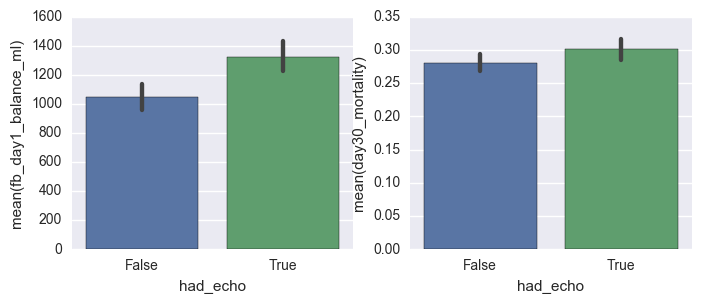

In [21]:
nrows, ncols = 1, 2

fig = plt.figure(figsize=(8,3))  
sns.set(font_scale=1)
cur_ax = fig.add_subplot(nrows, ncols, 1)
sns.barplot(x = 'had_echo', y = 'fb_day1_balance_ml', data = sepsis)
cur_ax = fig.add_subplot(nrows, ncols, 2)
sns.barplot(x = 'had_echo', y = 'day30_mortality', data = sepsis)

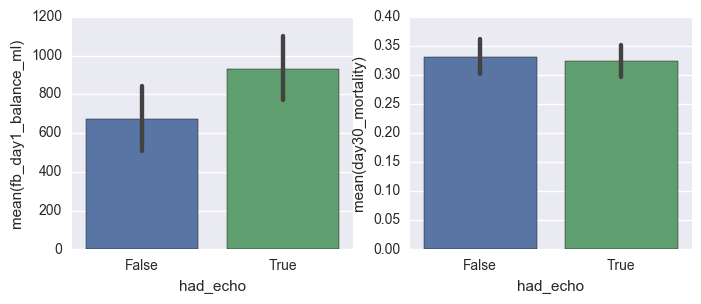

In [22]:
nrows, ncols = 1, 2

fig = plt.figure(figsize=(8,3))  
sns.set(font_scale=1)
cur_ax = fig.add_subplot(nrows, ncols, 1)
sns.barplot(x = 'had_echo', y = 'fb_day1_balance_ml', data = chf)
cur_ax = fig.add_subplot(nrows, ncols, 2)
sns.barplot(x = 'had_echo', y = 'day30_mortality', data = chf)

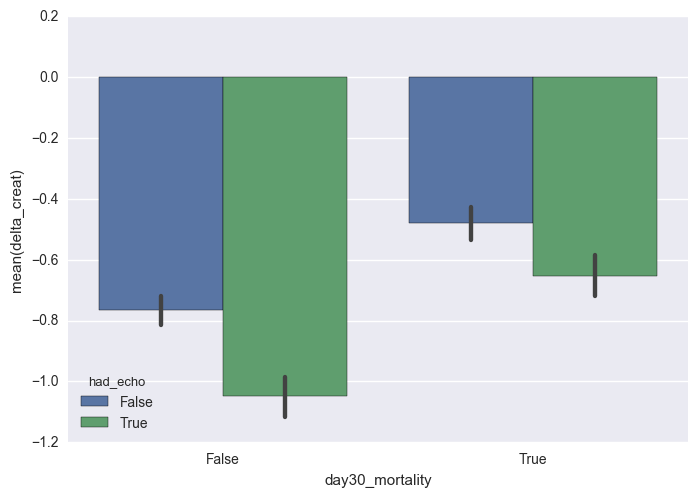

In [25]:
## for sepsis patients who got echos, do they get better outcome instead of lactate, creatinine
## survivors tend to have greater reduction in creatinine, having echo dropped creatinine even more. 
## need to adjust for apsiii
sns.barplot(x = 'day30_mortality', y ='delta_creat', hue= 'had_echo', data = sepsis)

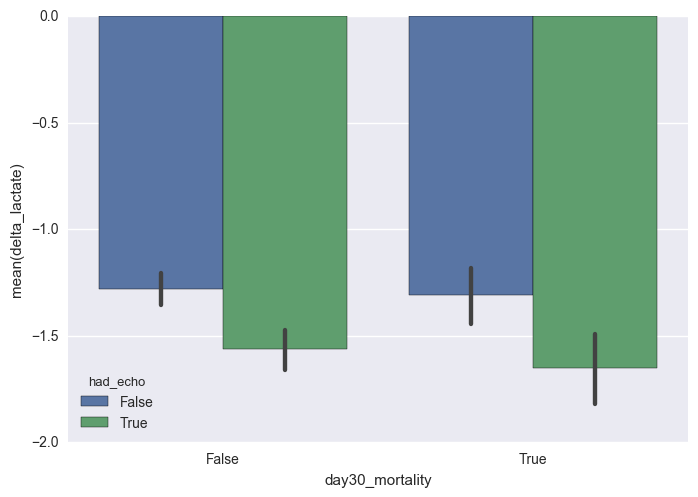

In [26]:
sns.barplot(x = 'day30_mortality', y ='delta_lactate', hue= 'had_echo', data = sepsis)

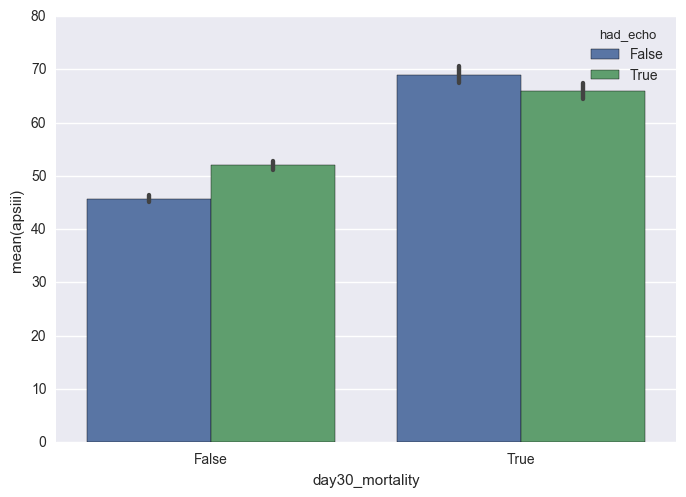

In [38]:
# patients who got echos tend to be sicker
sns.barplot(x = 'day30_mortality', y ='apsiii', hue= 'had_echo', data = sepsis)

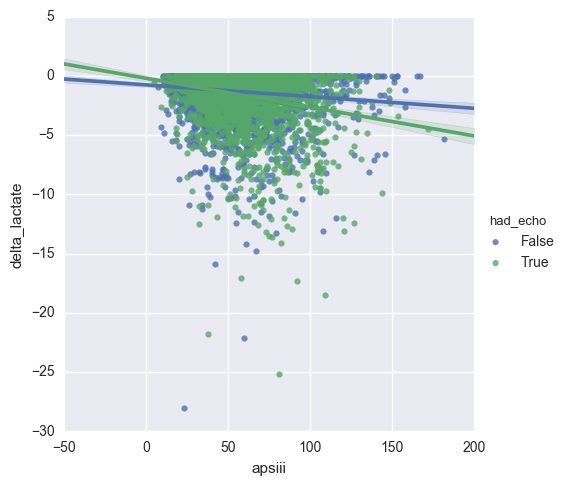

In [44]:
# creatinine recovered more for patients with echo.  
sns.lmplot(x='apsiii', y='delta_lactate', hue='had_echo', data=sepsis)

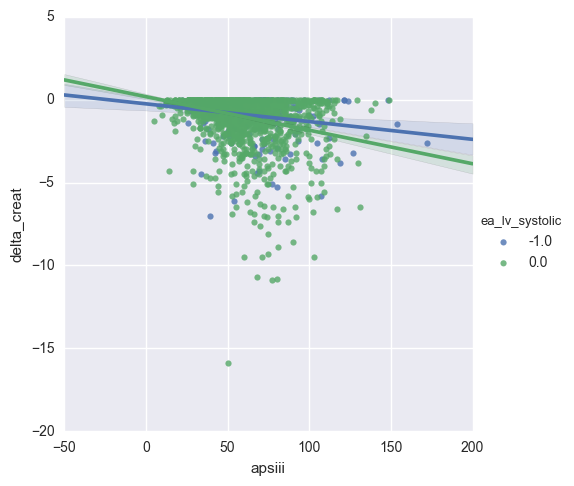

In [48]:
sns.lmplot(x='apsiii', y='delta_creat', hue='ea_lv_systolic', data=sepsis[sepsis.ea_lv_systolic.isin([-1,0])])

In [80]:
# echo sepsis group mortality and lv-systolic
table = df[df['passed_filters']==1].groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic   -3.0  -2.0  -1.0   0.0   1.0   2.0   3.0
day30_mortality                                          
False              26    63   267  2370   192   136   190
True               15    43   160   766    65    65   106

In [81]:
table /= table.sum(axis=0)
table

ea_lv_systolic       -3.0     -2.0      -1.0      0.0       1.0       2.0  \
day30_mortality                                                             
False            0.634146  0.59434  0.625293  0.75574  0.747082  0.676617   
True             0.365854  0.40566  0.374707  0.24426  0.252918  0.323383   

ea_lv_systolic        3.0  
day30_mortality            
False            0.641892  
True             0.358108

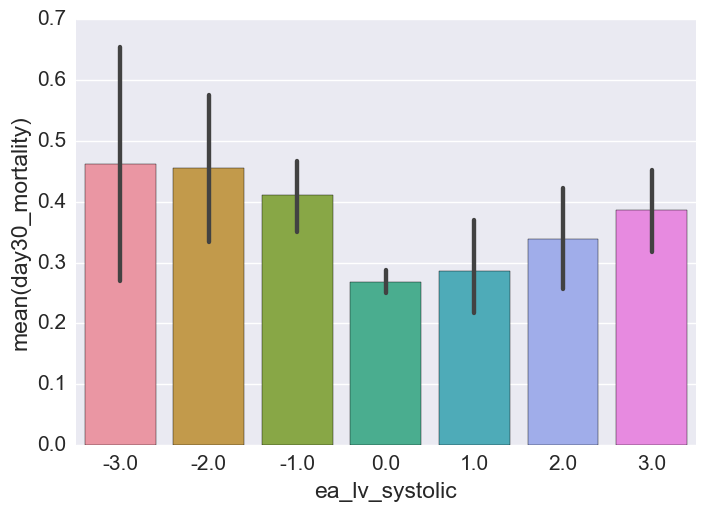

In [83]:
sns.set(font_scale=1.5)
sns.barplot(x="ea_lv_systolic", y ="day30_mortality", data = echo_sepsis)

In [84]:
# echo sepsis group mortality and lv-systolic
table = df[df['passed_filters']==1].groupby(['day30_mortality', 'ea_lv_diastolic']).size().unstack()
table

ea_lv_diastolic  -50.0  -3.0   -2.0    0.0    1.0    2.0    3.0 
day30_mortality                                                 
False              1.0   38.0  141.0  181.0   31.0   17.0   10.0
True               NaN   18.0   50.0   29.0    7.0    7.0    2.0

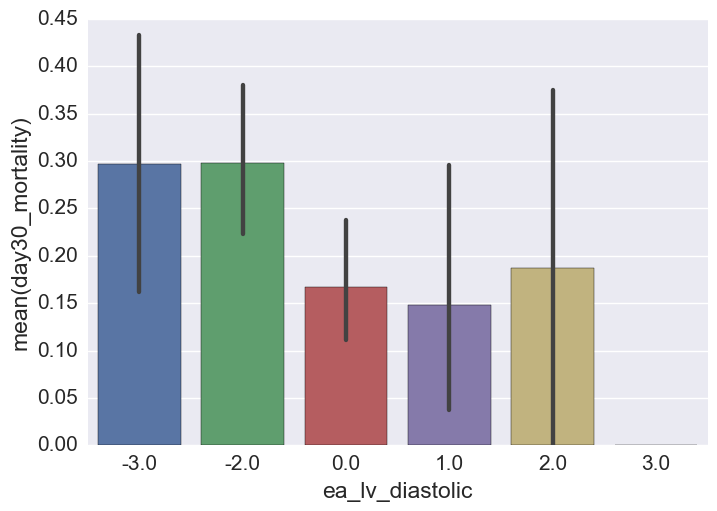

In [85]:
sns.set(font_scale=1.5)
sns.barplot(x="ea_lv_diastolic", y ="day30_mortality", data = echo_sepsis)

In [86]:
# echo sepsis group mortality 
table = df[df['passed_filters']==1].groupby(['day30_mortality', 'ea_tv_pulm_htn']).size().unstack()
table

ea_tv_pulm_htn   -50.0  -3.0    0.0    1.0    2.0    3.0 
day30_mortality                                          
False              1.0  638.0  504.0  912.0  683.0   74.0
True               NaN  172.0  141.0  337.0  351.0   51.0

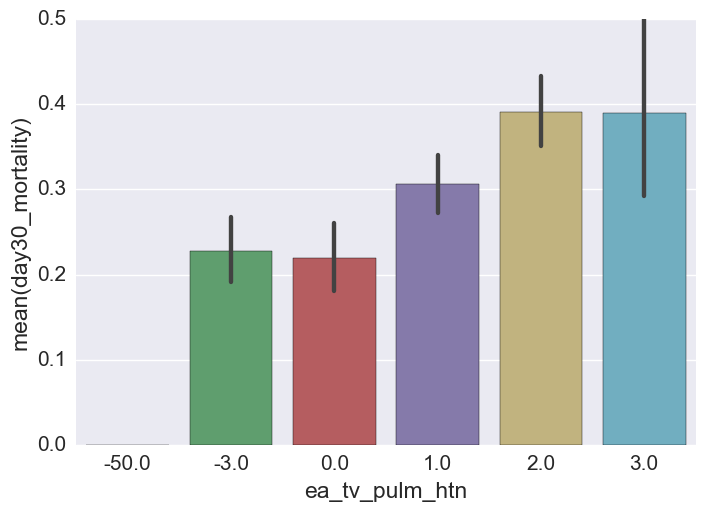

In [87]:
sns.set(font_scale=1.5)
sns.barplot(x="ea_tv_pulm_htn", y ="day30_mortality", data = echo_sepsis)

In [18]:
df.passed_filters.head()
# ((filter_vaso = True) OR (filter_angus_sepsis = True)) AND
#        (filter_hard_cardiogenic = False) AND
#        (filter_chronic_dialysis = False) AND
#        (filter_adult = True) AND
#        ((st_micu = True) OR (st_sicu = True) OR (st_nsicu = True))

0    NaN
1    1.0
2    NaN
3    NaN
4    NaN
Name: passed_filters, dtype: float64

lv_systolic.txt: 
====-3
Cannot assess LVEF
LV not well seen
Overall left ventricular systolic function cannot be reliably assessed
The left ventricle is not well seen
====-2
depressed LVEF
Depressed LVEF
global LV hypokinesis
Intrinsic LV systolic function depressed given the severity of valvular regurgitation
Intrinsic LV systolic function likely depressed given the of valvular regurgitation
Intrinsic LV systolic function likely depressed given the severity of regurgitation
Intrinsic LV systolic function likely depressed given the severity of valvular regurgitation
LV systolic function appears depressed
====-1
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF
Hyperdynamic LVEF (>75%)
Hyperdynamic LVEF >75%
Left ventricular systolic function is hyperdynamic (EF>75%)
====0
Left ventricular wall thickness, cavity size, and systolic function are normal
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Low normal LVEF
Low normal LVEF (50-55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Normal LV wall thickness, cavity size and regional/global function (LVEF >55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Normal LV wall thickness, cavity size, and global function (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Overall normal LVEF (>55%)
There is mild symmetric left ventricular hypertrophy with normal cavity size and systolic function
There is mild symmetric left ventricular hypertrophy with normal cavity size and systolic function (LVEF>55%)
====1
Mild global LV hypokinesis
Mildly depressed LVEF
Mildly depressed LVEF (40-55%)
Mildly depressed LVEF Mild global LV hypokinesis
Overall left ventricular systolic function is mildly depressed
There is mild global left ventricular hypokinesis
====2
Mild-moderate global left ventricular hypokinesis
Moderate global LV hypokinesis
Moderately depressed
Moderately depressed LVEF
Moderately depressed LVEF (30-39%)
Overall left ventricular systolic function is moderately depressed
There is moderate global left ventricular hypokinesis
====3
Moderate-severe global left ventricular hypokinesis
Overall left ventricular systolic function is severely depressed
Overall left ventricular systolic function is severely depressed -severe global left ventricular hypokinesis
severe global left ventricular hypokinesis
Severe global LV hypokinesis
Severely depressed LVEF
Severely depressed LVEF (<30%)
There is severe global left ventricular hypokinesis

In [89]:
echo_sepsis.describe()

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


icustay_id        hadm_id    subject_id  \
count    3033.000000    3033.000000   3033.000000   
mean   246589.092318  149468.131223  41003.712826   
std     29051.409652   29133.865827  29549.684996   
min    200030.000000  100035.000000     52.000000   
25%    221142.000000  124278.000000  15626.000000   
50%    245085.000000  149801.000000  30139.000000   
75%    271137.000000  174463.000000  66603.000000   
max    299956.000000  199925.000000  99985.000000   

                                 age       height       weight       ed_bsa  \
count                           3033  2797.000000  3027.000000  2519.000000   
mean      15341 days 19:23:09.073639   168.404754    60.384521     1.924732   
std       31666 days 23:03:11.939726    13.095111    31.091696     0.308916   
min    -104004 days +01:11:25.290448    12.700000    12.655227     0.530000   
25%              18475 days 19:24:00          NaN          NaN          NaN   
50%              23514 days 16:01:15          NaN          NaN          NaN   
75%              28218 days 19:25:26          NaN          NaN          NaN   
max              32475 days 16:01:07   345.440000   286.632625     6.030000   

          ed_bpsys    ed_bpdias        ed_hr      ...            pc_echo  \
count  2953.000000  2953.000000  2800.000000      ...        2511.000000   
mean    118.628175    62.053844    89.755714      ...           0.430904   
std      39.935287    36.161086    26.777029      ...           0.495301   
min      58.000000     0.000000    34.000000      ...           0.000000   
25%            NaN          NaN          NaN      ...                NaN   
50%            NaN          NaN          NaN      ...                NaN   
75%            NaN          NaN          NaN      ...                NaN   
max     990.000000   963.000000   800.000000      ...           1.000000   

        pc_pressor  pc_rhc  pc_thora  pc_vent  passed_filters  use_record  \
count  2511.000000  2511.0    2511.0   2511.0          3033.0      3033.0   
mean      0.005575     0.0       0.0      0.0             1.0         1.0   
std       0.074475     0.0       0.0      0.0             0.0         0.0   
min       0.000000     0.0       0.0      0.0             1.0         1.0   
25%            NaN     NaN       NaN      NaN             1.0         1.0   
50%            NaN     NaN       NaN      NaN             1.0         1.0   
75%            NaN     NaN       NaN      NaN             1.0         1.0   
max       1.000000     0.0       0.0      0.0             1.0         1.0   

               bmi  delta_creat  delta_lactate  
count  2793.000000  3033.000000    2827.000000  
mean     23.661157    -0.929443      -1.589126  
std      98.593615     1.389515       2.254543  
min       2.964934   -15.900000     -25.200000  
25%            NaN    -1.100000            NaN  
50%            NaN    -0.400000            NaN  
75%            NaN    -0.200000            NaN  
max    4216.008432     0.000000       0.000000  

[8 rows x 123 columns]

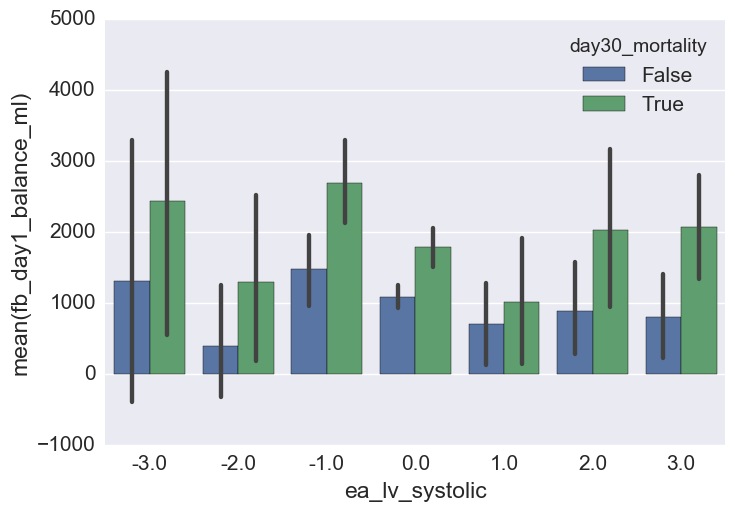

In [90]:
#plt.scatter(df.ea_lv_systolic, df.creatinine_max)
sns.barplot(x="ea_lv_systolic", y="fb_day1_balance_ml", hue = 'day30_mortality', data=echo_sepsis);

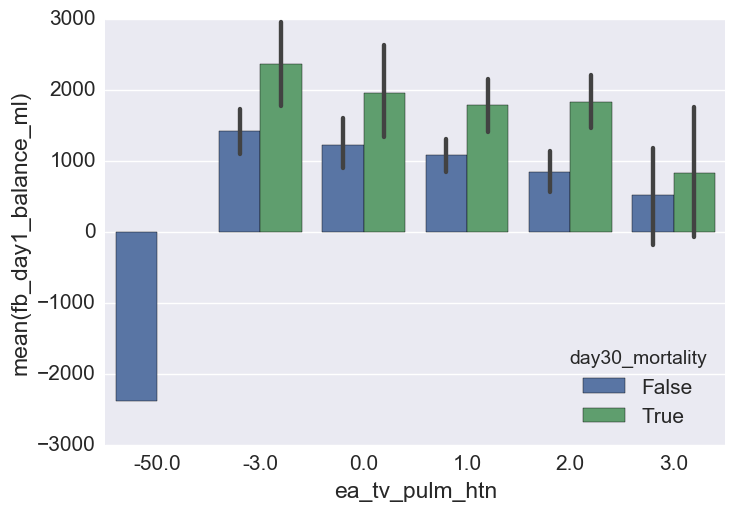

In [91]:
sns.barplot(x="ea_tv_pulm_htn", y="fb_day1_balance_ml", hue = 'day30_mortality', data=echo_sepsis);

In [93]:
# echo use and mortality?? 
sns.barplot(x="ea_lv_systolic", y="day30_mortality", hue = 'echo_use', data=df);

ValueError: Could not interpret input 'echo_use'

In [94]:
#echo_sepsis.filter(regex= 'ea_*_*').columns.tolist()
echo_feature_names = ['ea_tv_pulm_htn',
 'ea_tv_regurgitation',
 'ea_tv_stenosis',
 'ea_lv_cavity',
 'ea_lv_diastolic',
 'ea_lv_systolic',
 'ea_lv_wall',
 'ea_rv_cavity',
 'ea_rv_volume_overload',
 'ea_rv_systolic',
 'ea_rv_wall',
 'ea_av_regurgitation',
 'ea_av_stenosis',
 'ea_mv_regurgitation',
 'ea_mv_stenosis',
 'ea_la_cavity',
 'ea_ra_dilated',
 'ea_ra_pressure']

In [95]:
echo_feature_names.count

<function list.count>

# echo features and fluid balance

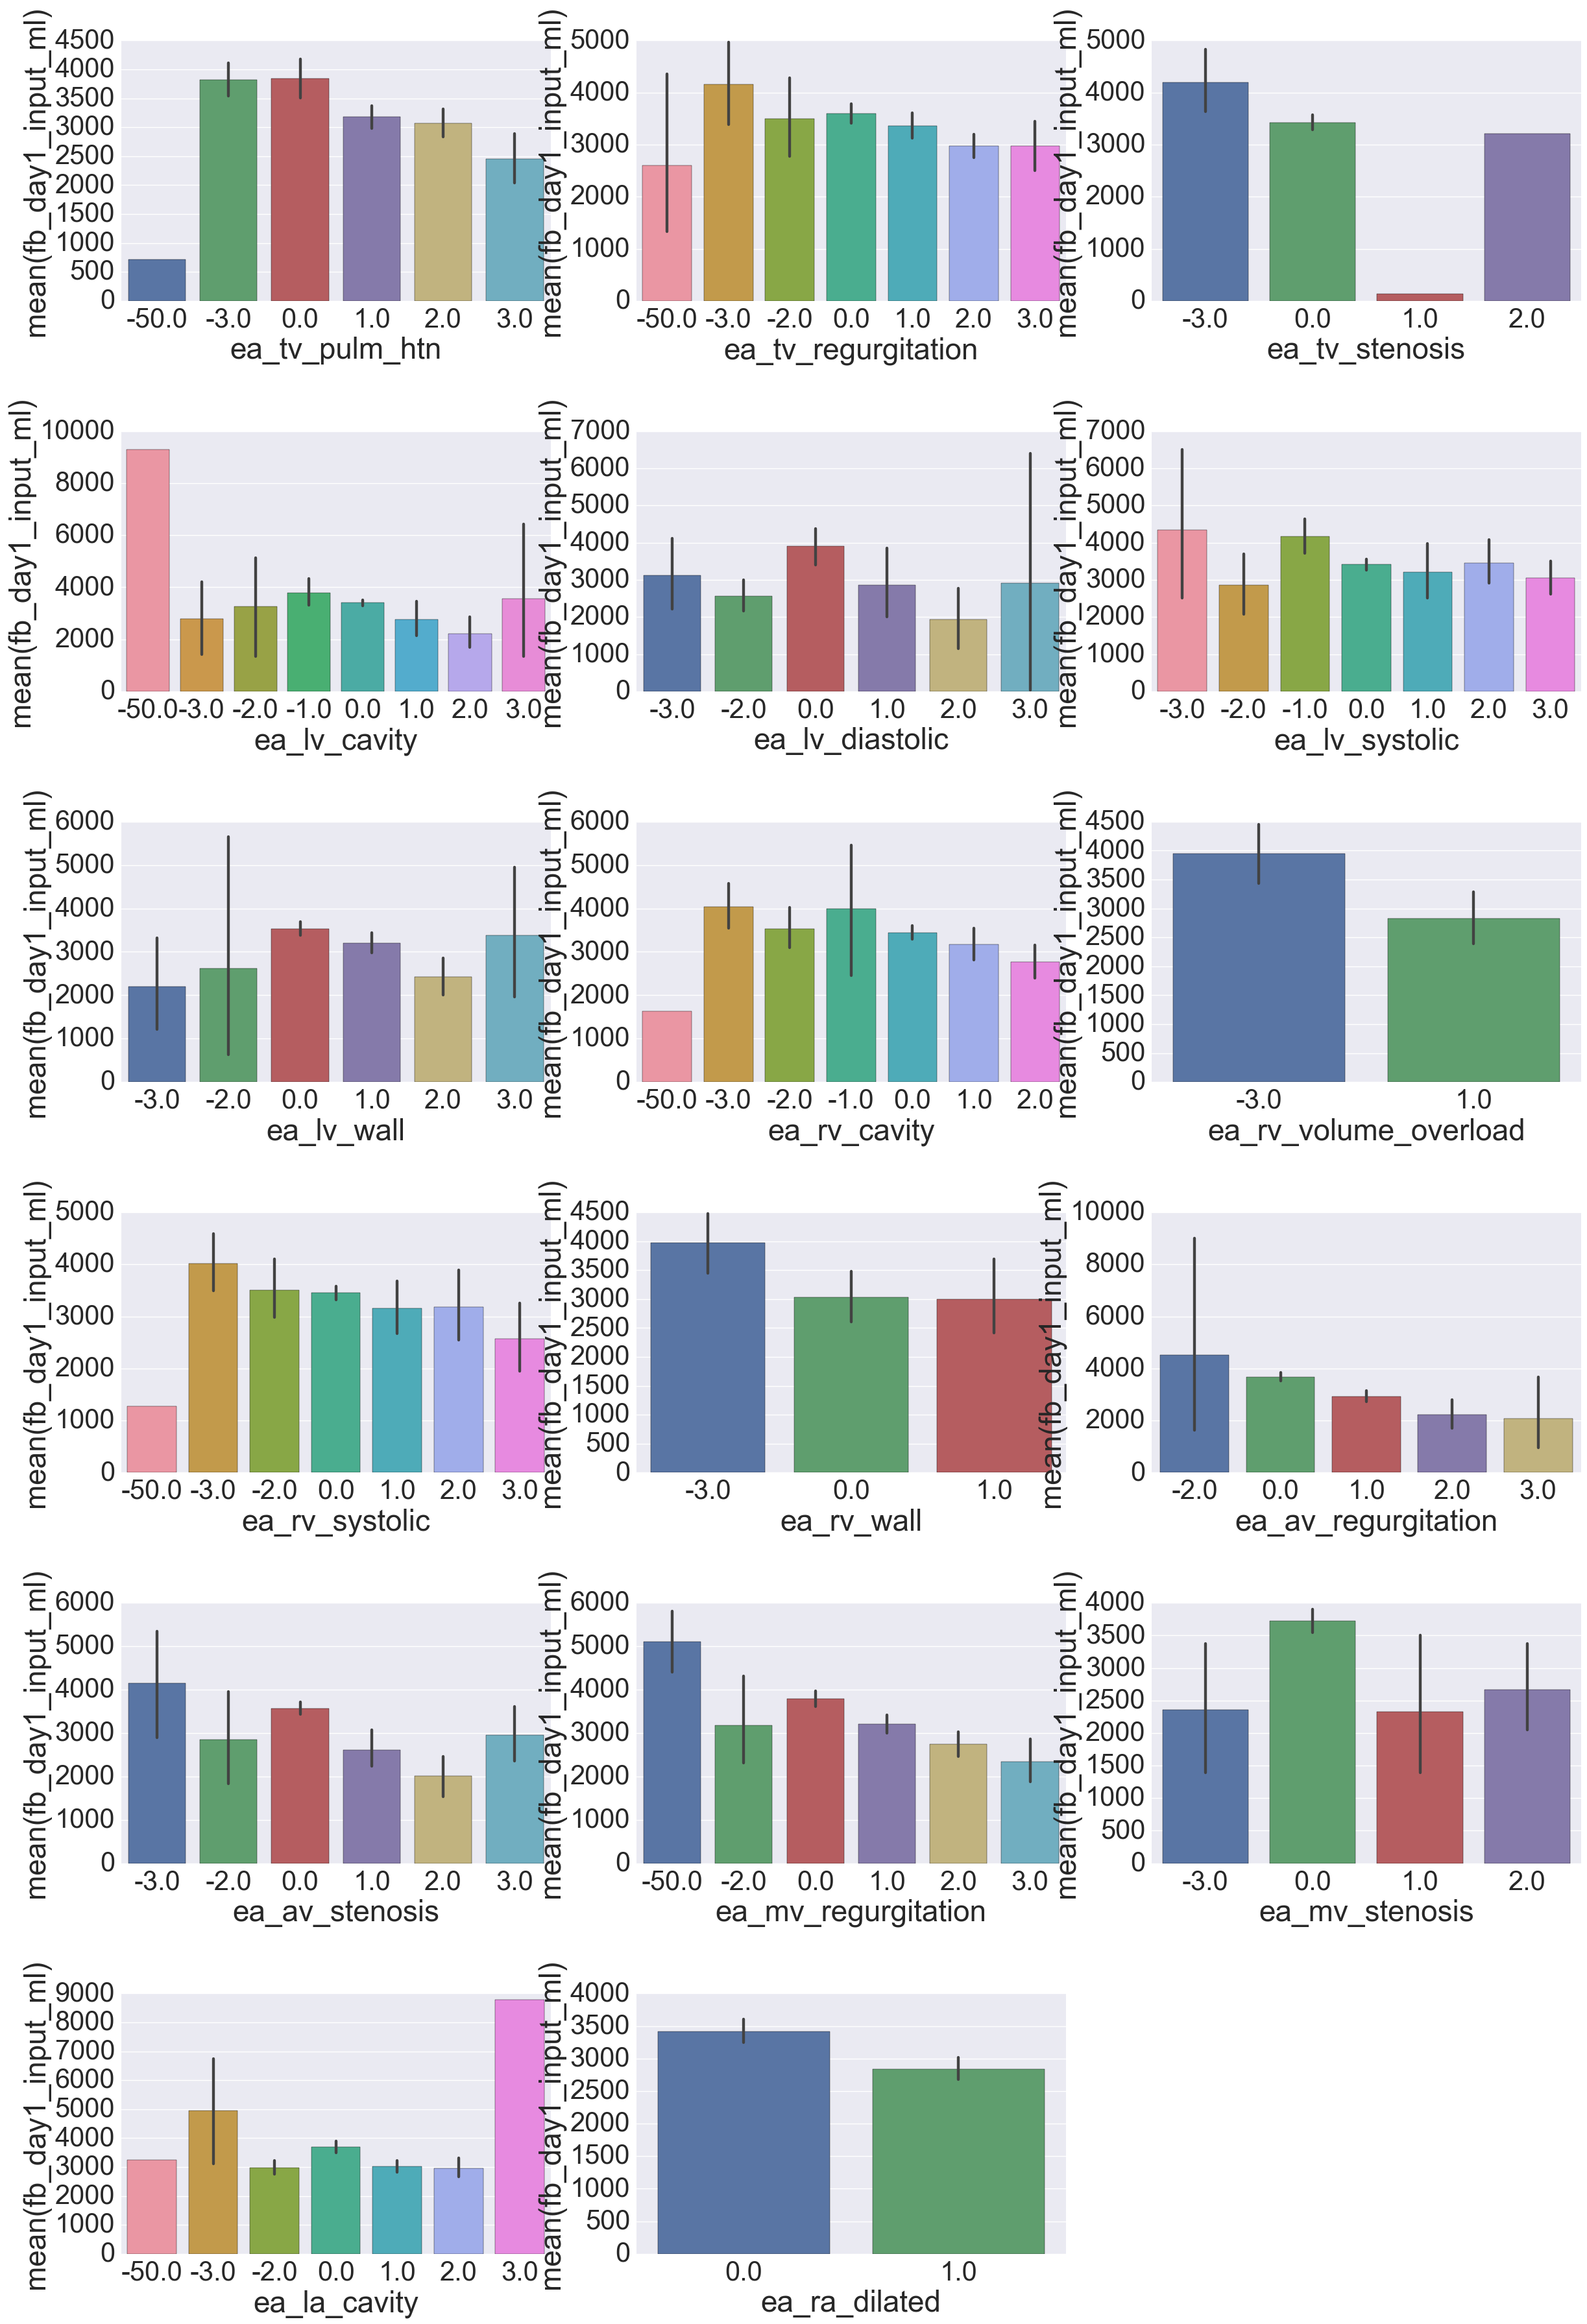

In [96]:
# most interesting are pulm_htn, and lv_systolic
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y ="fb_day1_input_ml", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

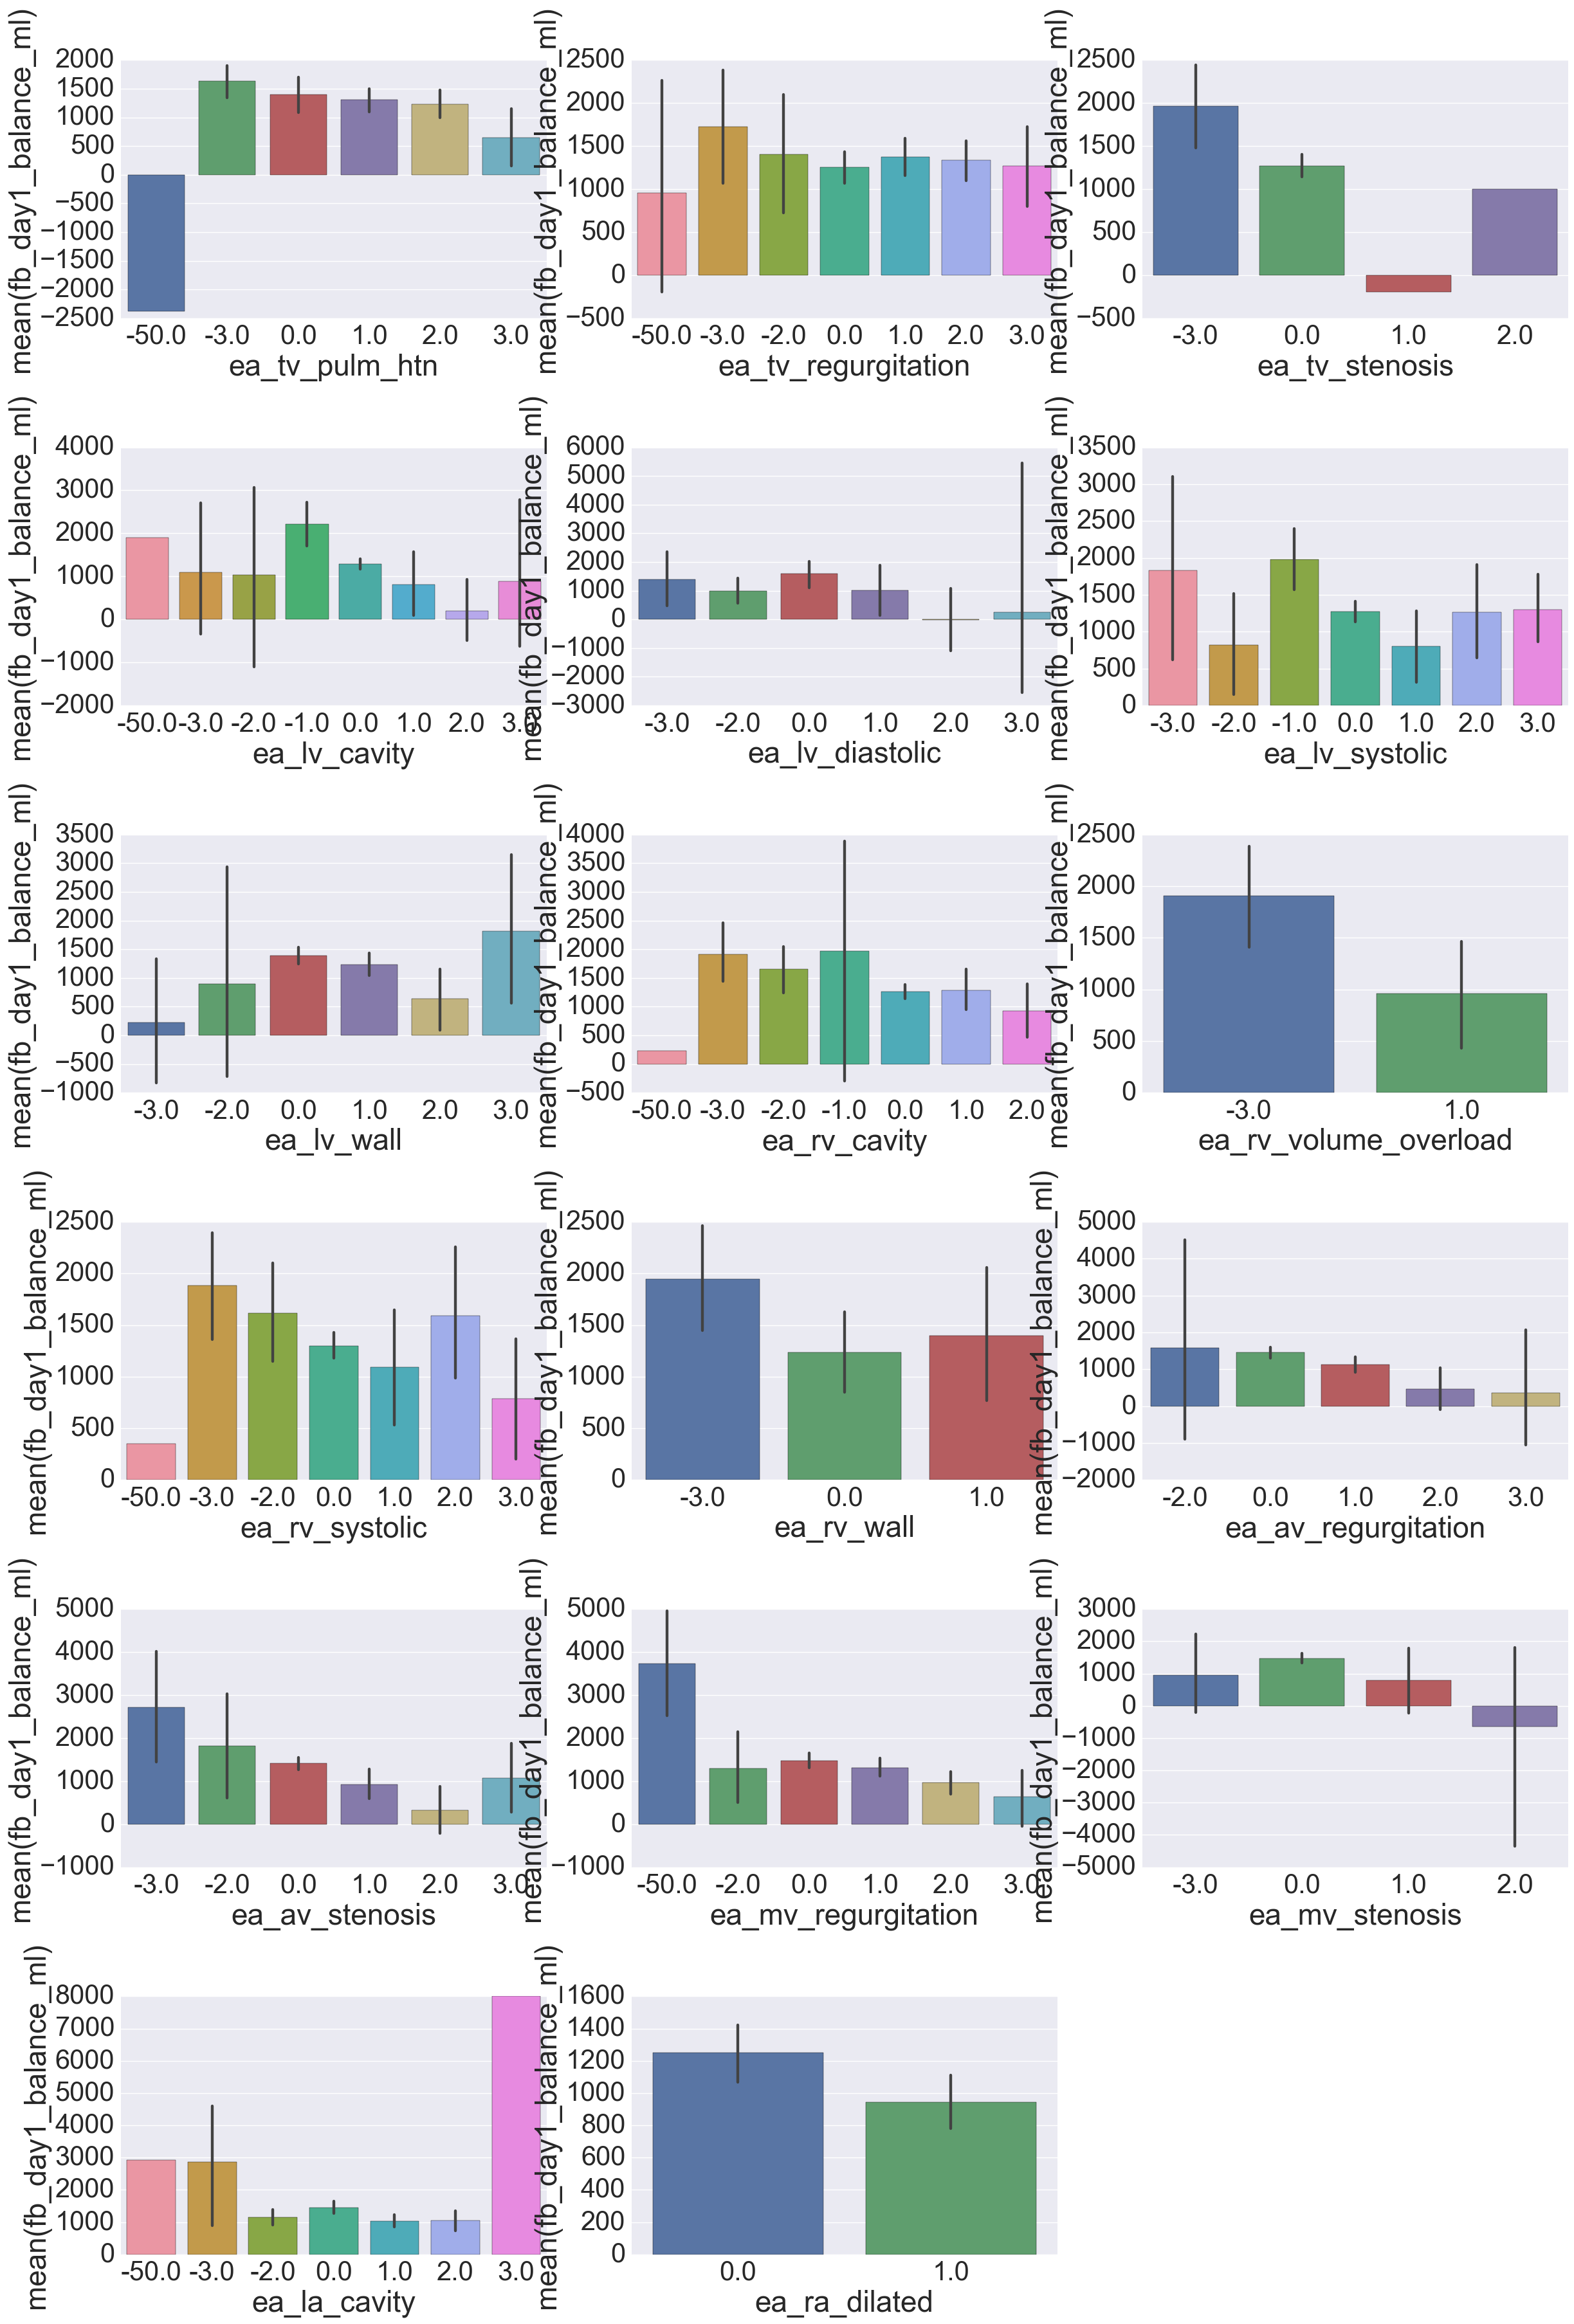

In [98]:
# most interesting are pulm_htn, and lv_systolic
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y ="fb_day1_balance_ml", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

# Mortality and echo features

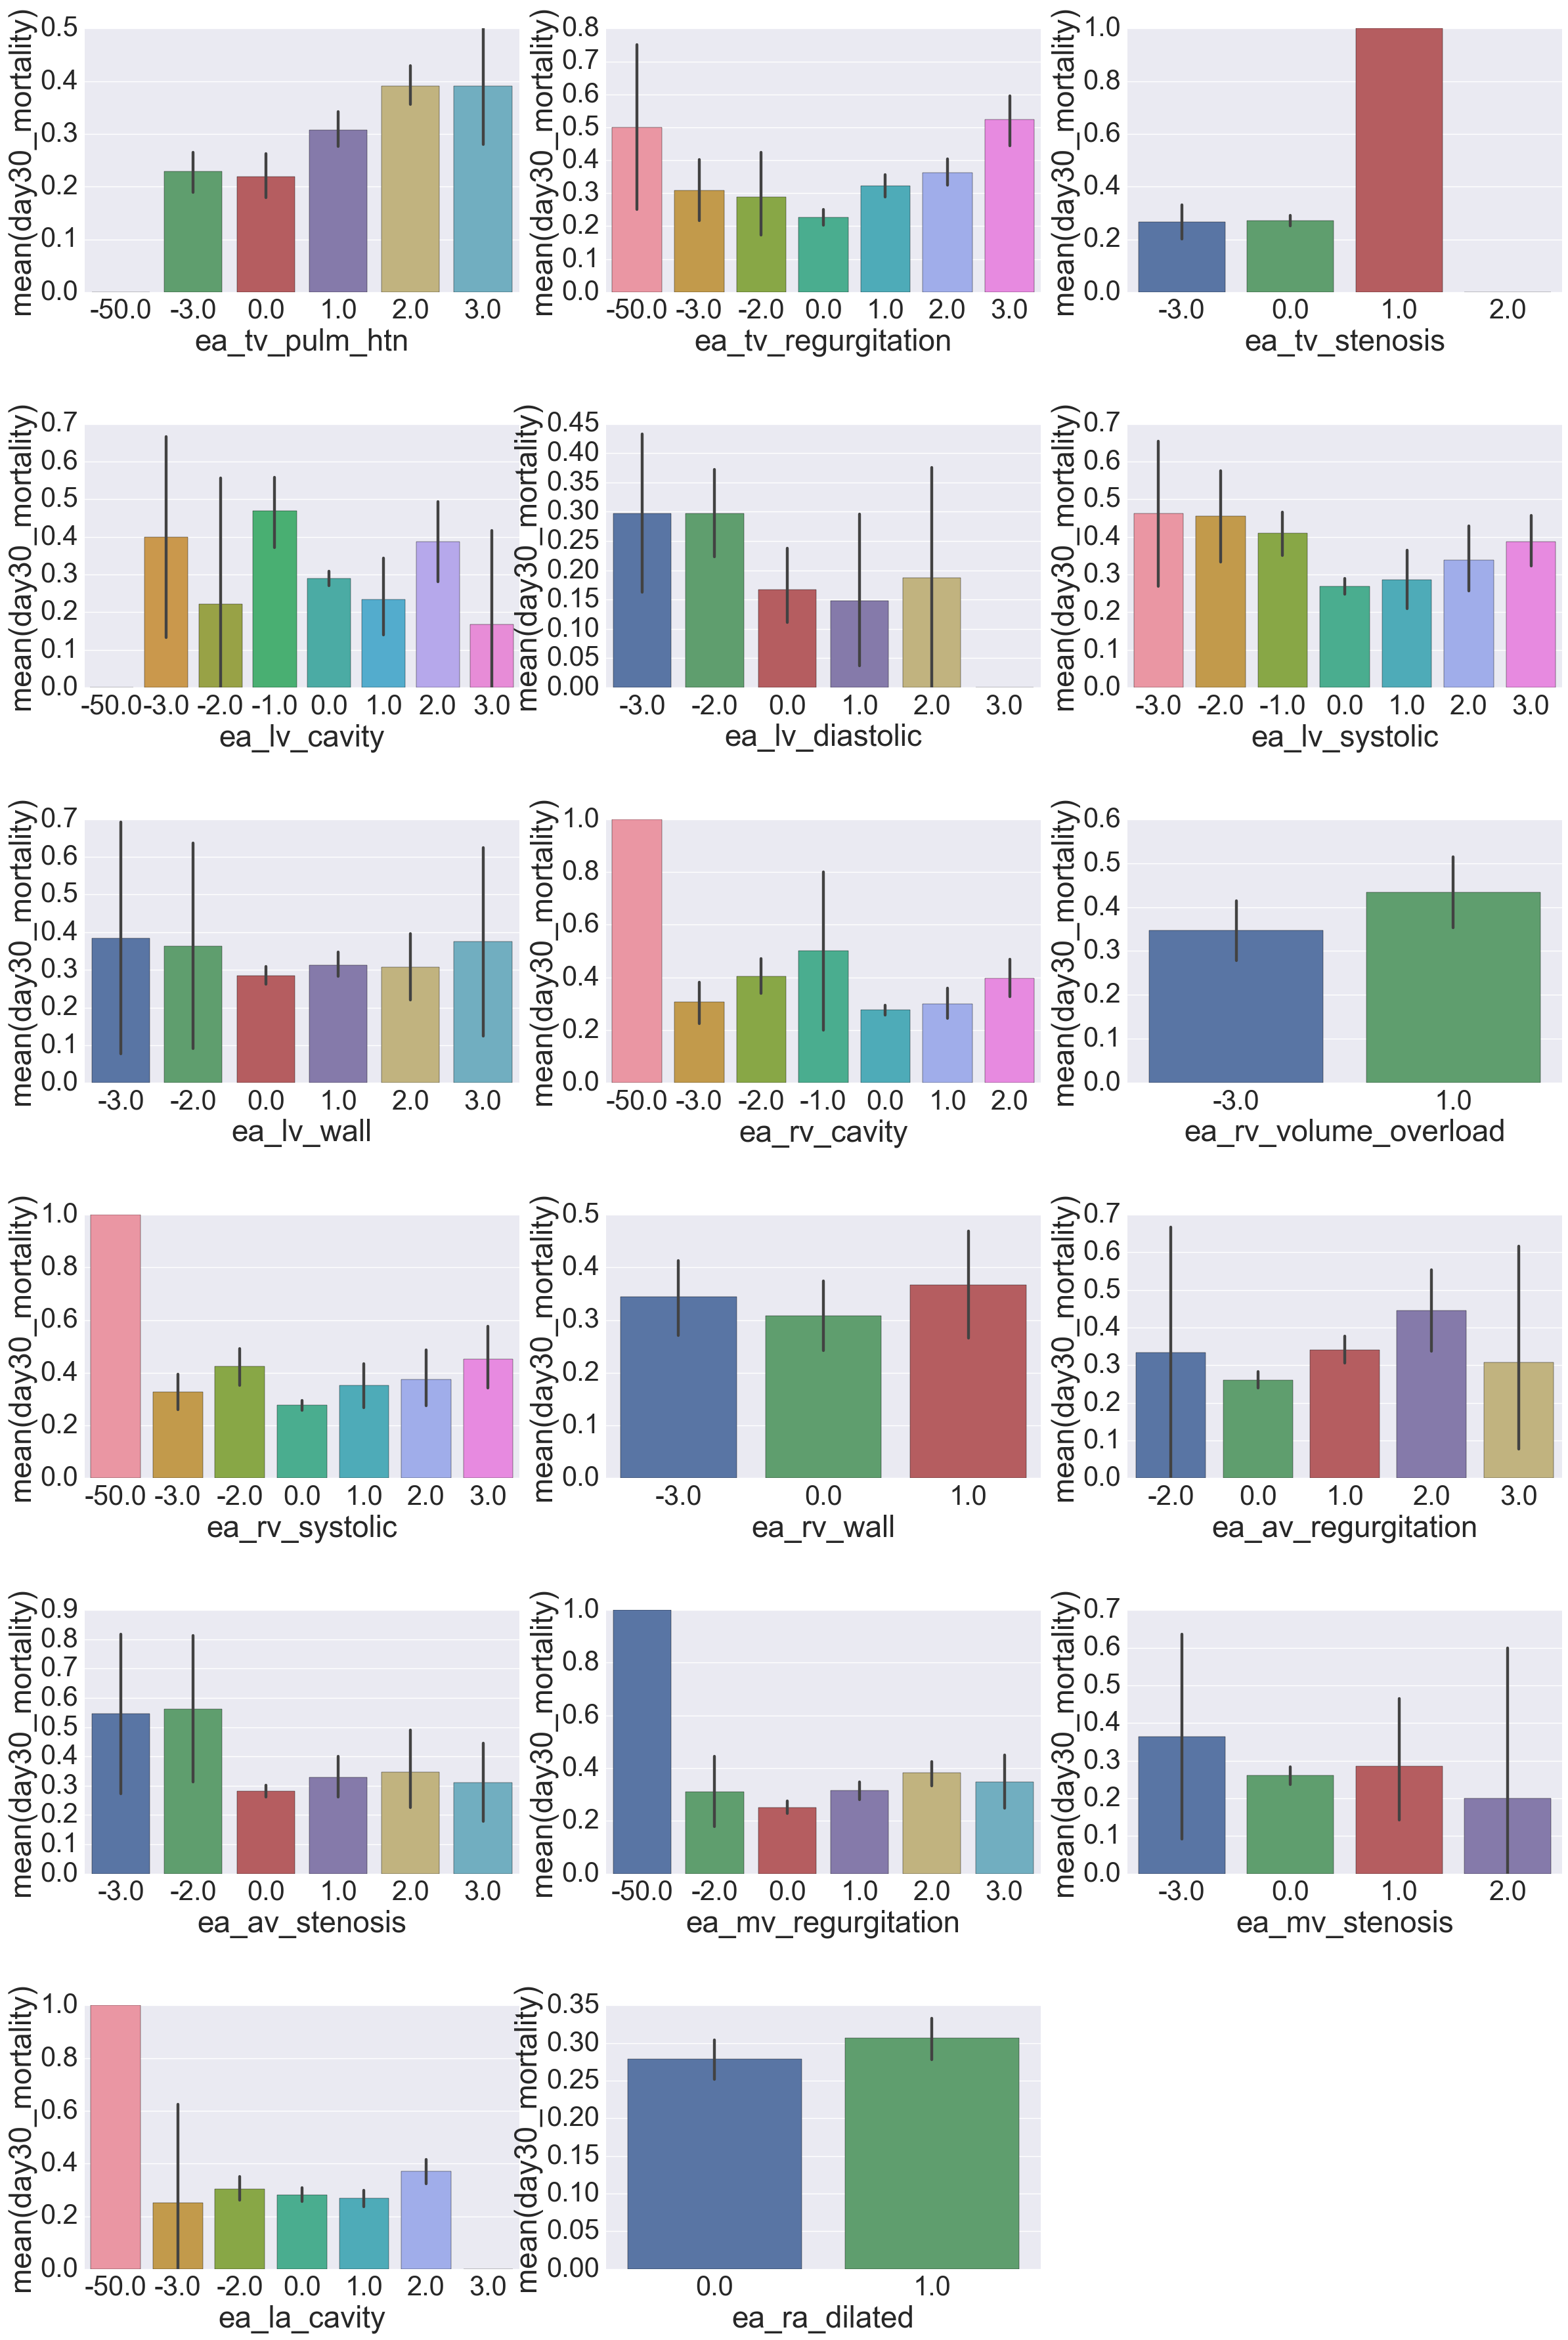

In [99]:
# most interesting are pulm_htn, and lv_systolic
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y ="day30_mortality", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

# More fluid associated with higher mortality.  

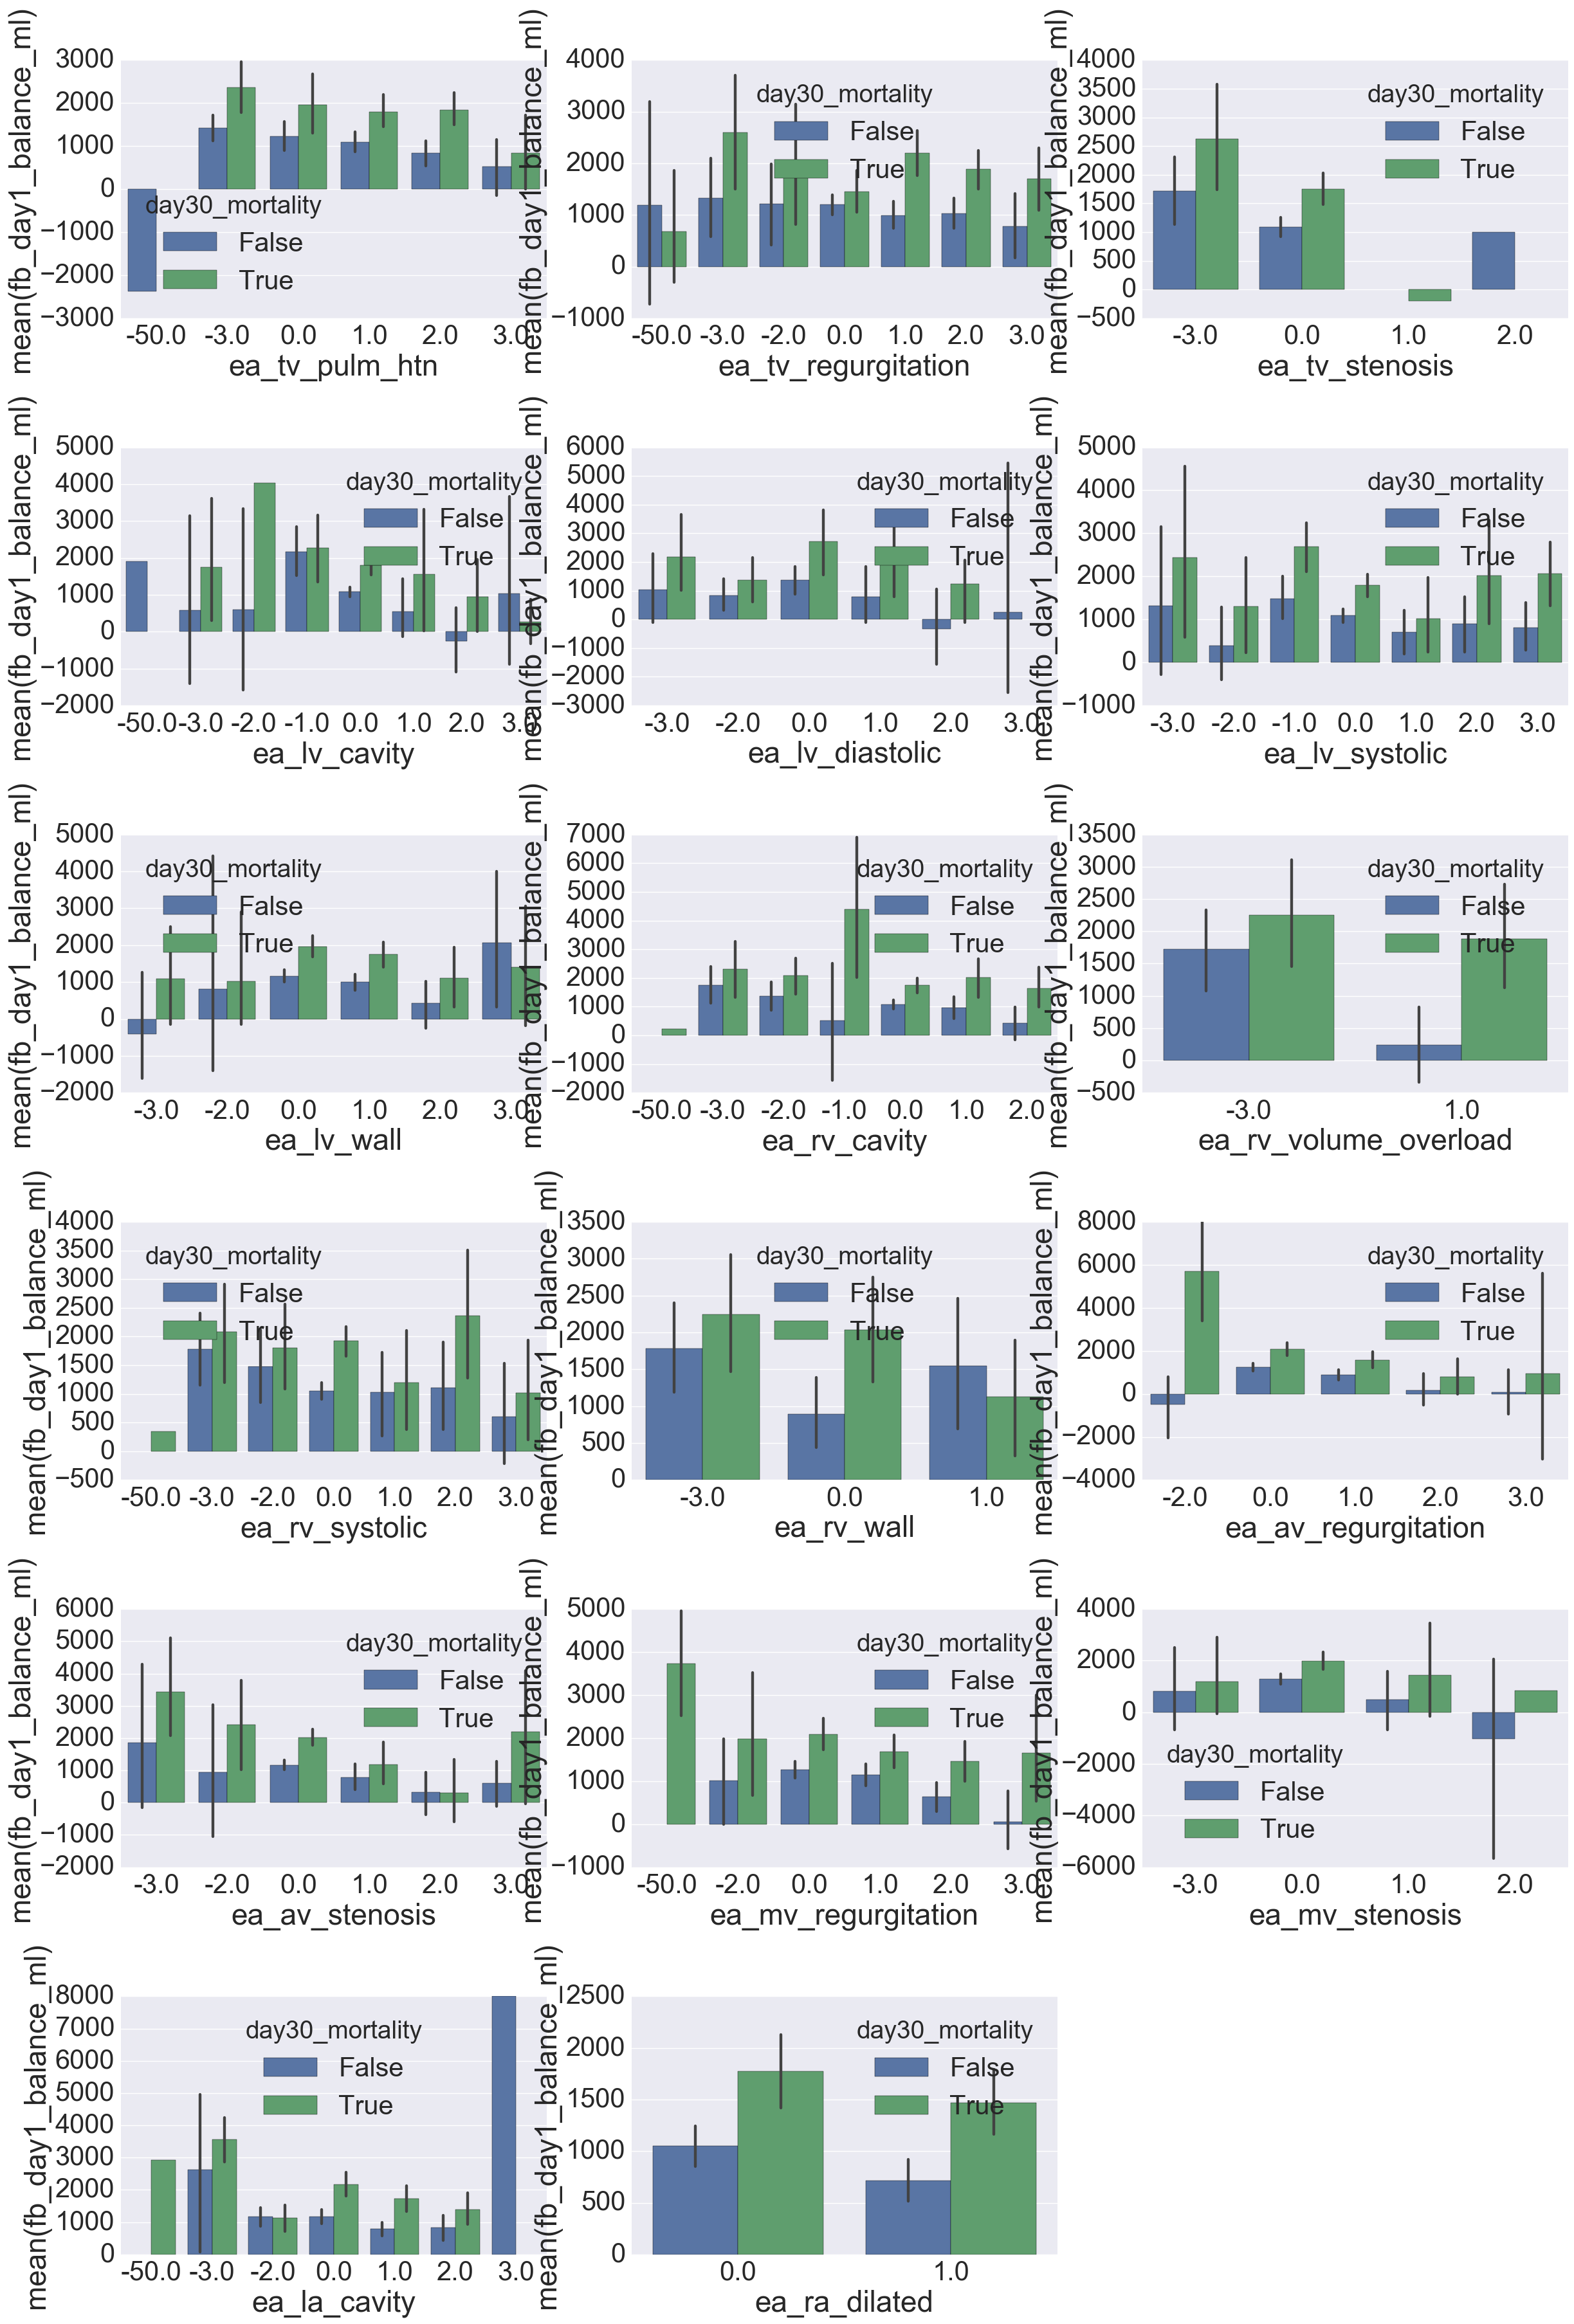

In [100]:
# tv_regurgitation, lV_systolic, 
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y = 'fb_day1_balance_ml', hue ="day30_mortality", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

In [101]:
def plot_relate_echo_feature_to(feature_name, dd):
    
    limited_echo_feature_names = ['ea_tv_pulm_htn','ea_lv_systolic']

    nrows, ncols = 1, 2
    #x = np.linspace(0,10,100)

    fig = plt.figure()  
    sns.set(font_scale=3)
    for i in range(1,3):
        cur_ax = fig.add_subplot(nrows, ncols, i)
        #ax.plot(x, x**i)
        sns.barplot(x= limited_echo_feature_names[i-1], y =feature_name,data = dd, ax = cur_ax)
        #cur_ax.set_title(echo_feature_names[i])
        cur_ax.set_title(' ')
    fig.subplots_adjust(right=2)
    plt.show()

In [102]:
def plot_relate_echo_feature_and_mortality_to(feature_name, dd):
    
    limited_echo_feature_names = ['ea_tv_pulm_htn','ea_lv_systolic']

    nrows, ncols = 1, 2
    #x = np.linspace(0,10,100)

    fig = plt.figure()  
    sns.set(font_scale=3)
    for i in range(1,3):
        cur_ax = fig.add_subplot(nrows, ncols, i)
        #ax.plot(x, x**i)
        sns.barplot(x= limited_echo_feature_names[i-1], y =feature_name, hue= 'day30_mortality',data = dd, ax = cur_ax)
        #cur_ax.set_title(echo_feature_names[i])
        cur_ax.set_title(' ')
    fig.subplots_adjust(right=2)
    plt.show()

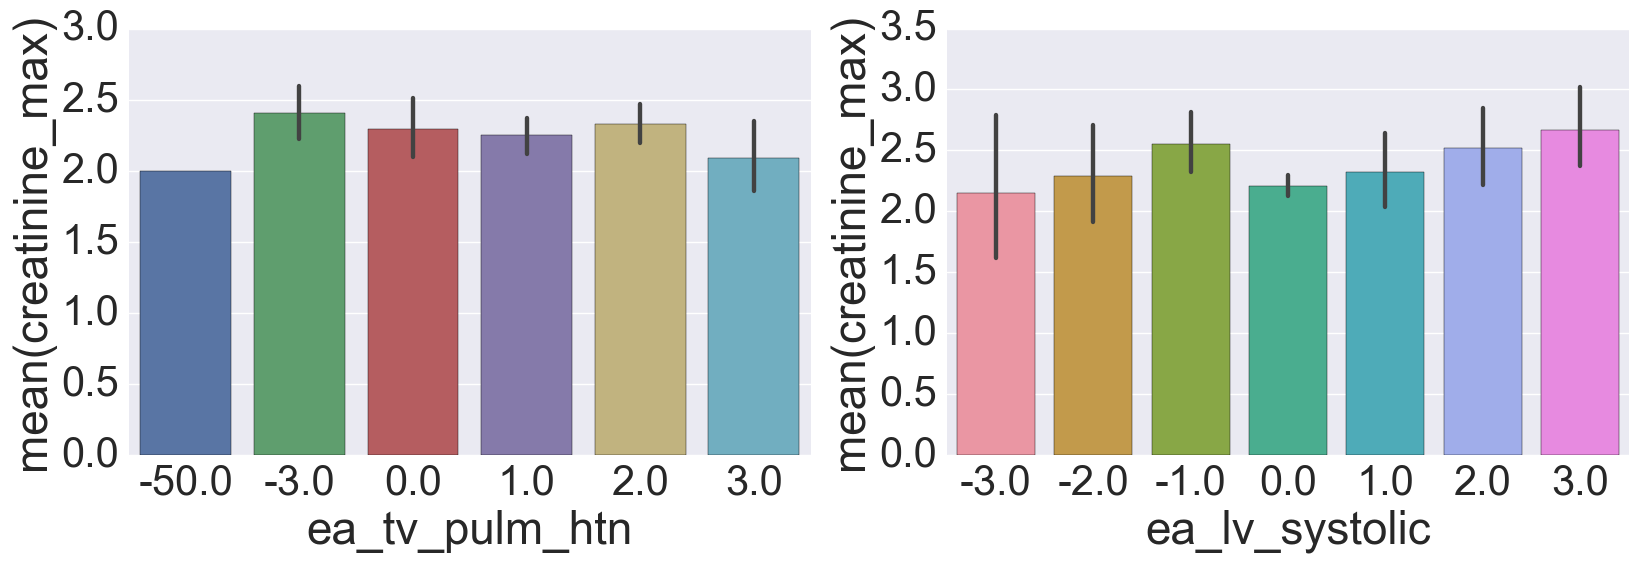

In [103]:
# higher creatinine associated with higher mortality
plot_relate_echo_feature_to('creatinine_max', echo_sepsis)

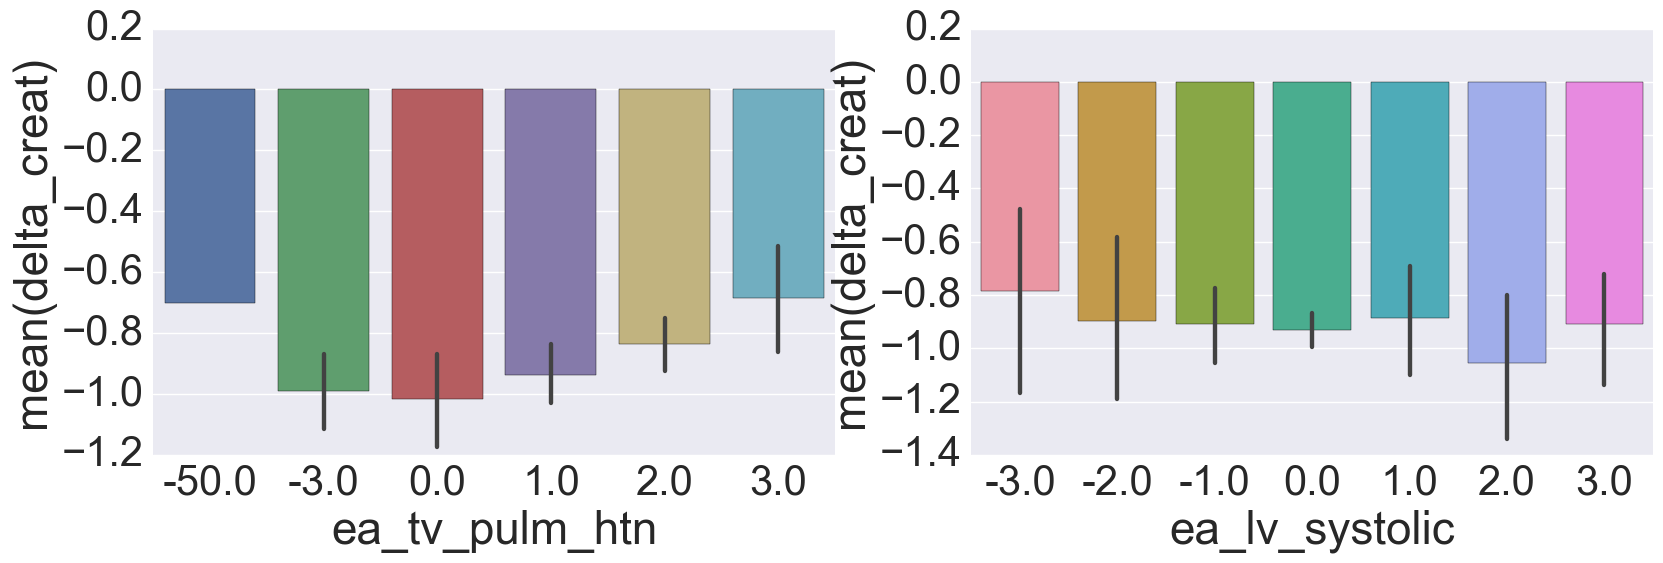

In [104]:
# smaller change in creatinine related to higher mortality.
# pulmonary hypertension predictive of creatinine change?? 
plot_relate_echo_feature_to('delta_creat', echo_sepsis)

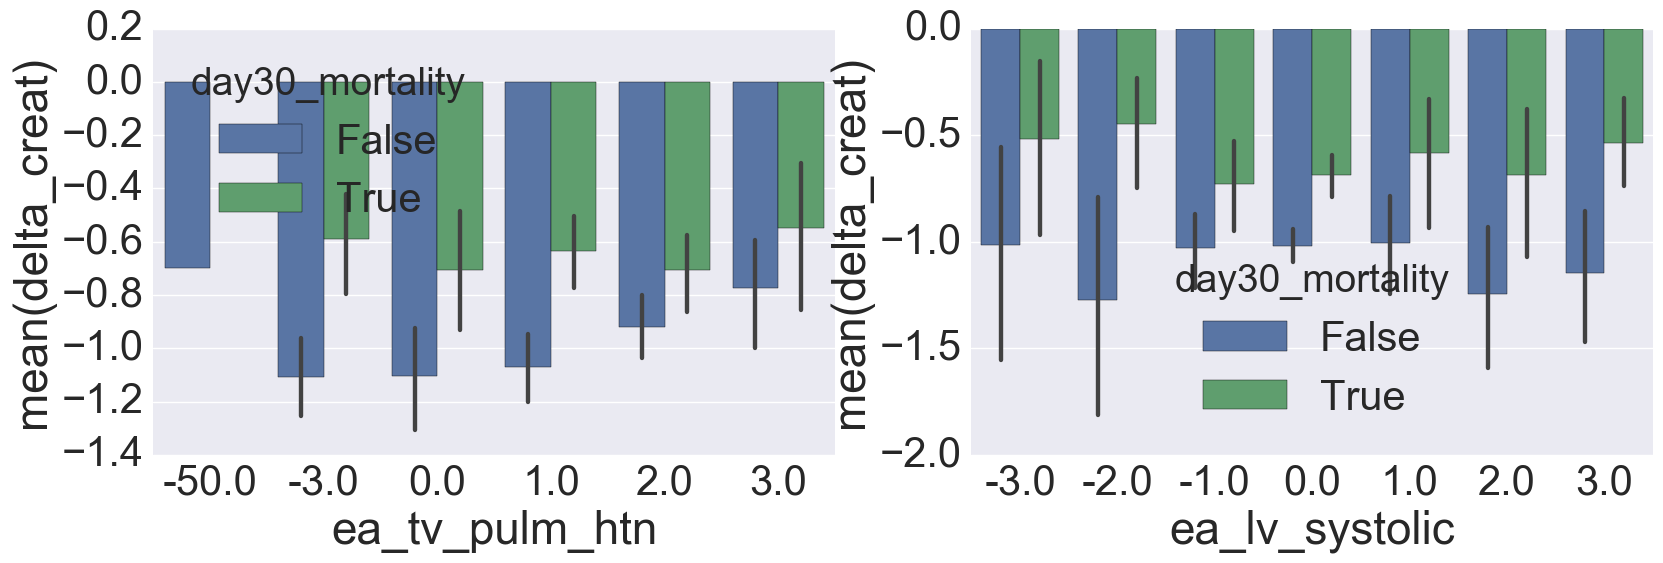

In [105]:
plot_relate_echo_feature_and_mortality_to('delta_creat', echo_sepsis)

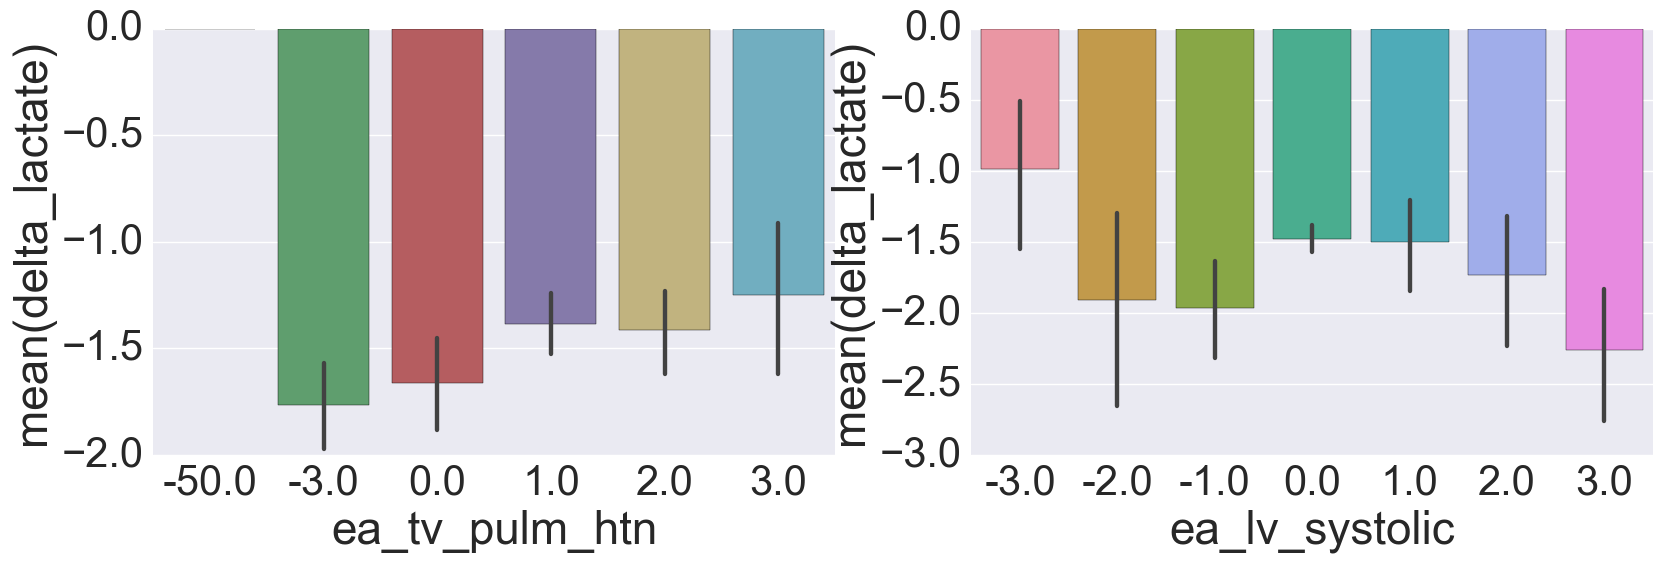

In [106]:
# higher creatinine associated with higher mortality
plot_relate_echo_feature_to('delta_lactate', echo_sepsis)

In [108]:
## multiple echos and how echo parameter change
echo_sepsis.columns.tolist()

['icustay_id',
 'hadm_id',
 'subject_id',
 'age',
 'gender',
 'height',
 'weight',
 'ethnicity',
 'insurance',
 'filter_vaso',
 'filter_chronic_dialysis',
 'filter_angus_sepsis',
 'filter_hard_cardiogenic',
 'filter_adult',
 'filter_echo',
 'ed_chartdate',
 'ed_charttime',
 'ed_quality',
 'ed_indication',
 'ed_bsa',
 'ed_bp',
 'ed_bpsys',
 'ed_bpdias',
 'ed_hr',
 'ed_test',
 'ed_doppler',
 'ed_contrast',
 'ea_hadm_id',
 'ea_new_time',
 'ea_key',
 'ea_height',
 'ea_weight',
 'ea_sys',
 'ea_diastolic',
 'ea_hr',
 'ea_tv_pulm_htn',
 'ea_tv_regurgitation',
 'ea_tv_stenosis',
 'ea_lv_cavity',
 'ea_lv_diastolic',
 'ea_lv_systolic',
 'ea_lv_wall',
 'ea_rv_cavity',
 'ea_rv_volume_overload',
 'ea_rv_systolic',
 'ea_rv_wall',
 'ea_av_regurgitation',
 'ea_av_stenosis',
 'ea_mv_regurgitation',
 'ea_mv_stenosis',
 'ea_la_cavity',
 'ea_ra_dilated',
 'ea_ra_pressure',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascu

In [148]:
counts_df = pd.DataFrame(echo_sepsis[['subject_id', 'ea_lv_systolic']].groupby(['subject_id']).size().rename('counts'))
#df['col1','col2','col3','col4'].groupby(['col1','col2']).mean()
#counts_df = pd.DataFrame(df.groupby('col1').size().rename('counts'))

In [184]:
# each ICU stay only has one echo... ???
counts_df = df[['icustay_id', 'ea_lv_systolic']].groupby(['icustay_id']).count()     
counts_df[counts_df.ea_lv_systolic>0].head()

ea_lv_systolic
icustay_id                
200003                   1
200009                   1
200014                   1
200019                   1
200025                   1

In [197]:
# a patient can have multiple echos
counts_df = df[['subject_id', 'ea_lv_systolic']].groupby(['subject_id']).count()     
# each ICU stay only has one echo... 
counts_df[counts_df.ea_lv_systolic>1].head()

ea_lv_systolic
subject_id                
36                       2
85                       2
109                      6
111                      2
124                      3

In [168]:
df.icustay_id.nunique()

61532

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


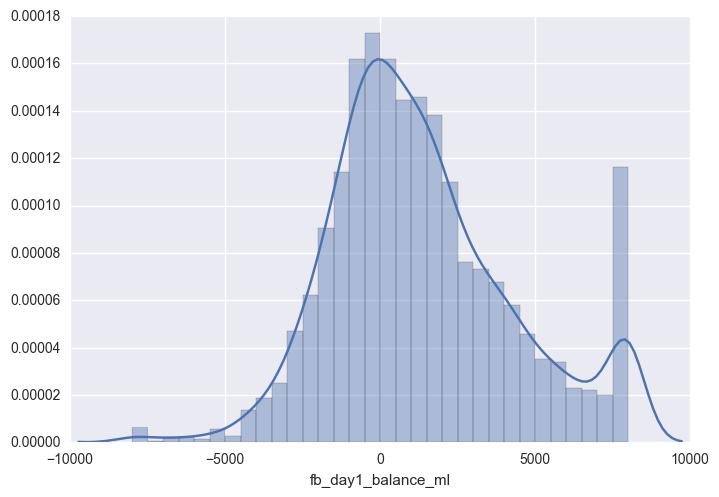

In [196]:
sns.set(font_scale=1)
sns.distplot(echo_sepsis[~np.isnan(echo_sepsis.fb_day1_balance_ml)].fb_day1_balance_ml)

# Create general feature table

In [259]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [261]:
## is apache score everr missing?
sum(np.isnan(df.apsiii))

0

In [292]:
sum(np.isnan(df.had_echo))

0

In [294]:
df.had_echo.astype(float)

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
5        0.0
6        0.0
7        0.0
8        1.0
9        0.0
10       0.0
11       0.0
12       1.0
13       0.0
14       0.0
15       0.0
16       0.0
17       1.0
18       1.0
19       1.0
20       1.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       1.0
        ... 
61502    0.0
61503    0.0
61504    1.0
61505    1.0
61506    1.0
61507    0.0
61508    0.0
61509    1.0
61510    0.0
61511    0.0
61512    0.0
61513    0.0
61514    0.0
61515    1.0
61516    0.0
61517    1.0
61518    0.0
61519    1.0
61520    0.0
61521    1.0
61522    0.0
61523    0.0
61524    1.0
61525    0.0
61526    0.0
61527    0.0
61528    1.0
61529    0.0
61530    0.0
61531    0.0
Name: had_echo, dtype: float64

In [278]:
def CreateFeatureTable(df):
    X = pd.DataFrame()

    # build the features table
    age = df.age/np.timedelta64('1', 'Y') # time in years
    age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
    age = normalize(age)
    age[age_masked] = 0
    X['age'] = age
    X['age_over_90'] = age_masked.astype(float)

    gender = df.gender
    gender = (gender == 'F').astype(float)
    X['gender'] = gender

    bmi = df.bmi
    bmi_missing = np.isnan(bmi)
    bmi = normalize(bmi)
    bmi[bmi_missing] = 0
    X['bmi'] = bmi
    X['bmi_missing'] = bmi_missing.astype(float)

    mech_vent = df.vf_first_day_vent.astype(float)
    X['mech_vent'] = mech_vent

    chf = df.ex_congestive_heart_failure.astype(float)
    X['CHF'] = chf

    mdrd = df.mdrd
    mdrd_missing = np.isnan(mdrd)
    mdrd = normalize(mdrd)
    mdrd[mdrd_missing] = 0
    X['mdrd'] = mdrd

    # MDRD missing is already largely covered by BMI missing
    # the only other missing values come from missing creatinine lab
    # so add that
    creatinine_missing = np.isnan(df.lab_creatinine)
    X['creatinine_missing'] = creatinine_missing.astype(float)

    apsiii = df.apsiii
    #apsiii_missing = np.isnan(apsiii)
    apsiii = normalize(apsiii)
    #apsiii[apsiii_missing] = 0
    X['apsiii'] = apsiii
    #X['apsiii_missing'] = apsiii_missing.astype(float)

    no_echo = np.isnan(df.ea_key)
    #X['no_echo'] = no_echo.astype(float)

    lvsys = df.ea_lv_systolic
    lv_missing = ((np.isnan(lvsys) | (lvsys < -1)) & ~no_echo).astype(float)
    lv_normal = (lvsys == 0).astype(float)
    lv_hyperdynamic = (lvsys == -1).astype(float)
    lv_mild_depressed = (lvsys == 1).astype(float)
    lv_mod_depressed = (lvsys == 2).astype(float)
    lv_sev_depressed = (lvsys == 3).astype(float)
    X['lv_missing'] = lv_missing
    X['lv_normal'] = lv_normal
    X['lv_hyper'] = lv_hyperdynamic
    X['lv_mild'] = lv_mild_depressed
    X['lv_moderate'] = lv_mod_depressed
    X['lv_severe'] = lv_sev_depressed

    tvpulm = df.ea_tv_pulm_htn
    tv_missing = ((np.isnan(tvpulm) | (tvpulm < -2)) & ~no_echo).astype(float)
    tv_normal = (tvpulm == 0).astype(float)
    tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
    X['plm_htn_missing'] = tv_missing
    X['plm_htn_normal'] = tv_normal
    X['plm_htn_abnormal'] = tv_abnormal

    rvcavity = df.ea_rv_cavity
    rvcav_missing = ((np.isnan(rvcavity) | (rvcavity < -2)) & ~no_echo).astype(float)
    rvcav_normal = (rvcavity == 0).astype(float)
    rvcav_small = (rvcavity == -1).astype(float)
    rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
    X['rvcav_missing'] = rvcav_missing
    X['rvcav_normal'] = rvcav_normal
    X['rvcav_small'] = rvcav_small
    X['rvcav_dilated'] = rvcav_dilated

    lactate = df.lab_lactate
    lactate_missing = np.isnan(lactate)
    lactate = normalize(lactate)
    lactate[lactate_missing] = 0
    X['lactate'] = lactate
    X['lactate_missing'] = lactate_missing.astype(float)

    ## which ICU was treating the patient
    sicu = df.st_sicu.astype(float)
    sicu[np.isnan(sicu)] = 0
    nsicu = df.st_nsicu.astype(float)
    nsicu[np.isnan(nsicu)] = 0
    micu = df.st_micu.astype(float)
    micu[np.isnan(micu)] = 0
    X['sicu'] = sicu
    X['nsicu'] = nsicu
    X['micu'] = micu

    X['had_echo'] = df.had_echo.astype(float)

        ## make the features table. include fluid balance on days 1,2,3 of ICU stay
    X_mortality = X.copy()

    fluid_day1 = df.fb_day1_balance_ml.values
    fl_missing = np.isnan(fluid_day1) | df.fb_day1_balance_truncated.eq(1).values # also filter insane fluid balances
    fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
    fluid_day1[fl_missing] = 0
    X_mortality['fluid_day1'] = fluid_day1
    X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

    fluid_day2 = df.fb_day2_balance_ml.values
    fl_missing = np.isnan(fluid_day2) | df.fb_day2_balance_truncated.eq(1).values
    fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
    fluid_day2[fl_missing] = 0
    X_mortality['fluid_day2'] = fluid_day2
    X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

    fluid_day3 = df.fb_day3_balance_ml.values
    fl_missing = np.isnan(fluid_day3) | df.fb_day3_balance_truncated.eq(1).values
    fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
    fluid_day3[fl_missing] = 0
    X_mortality['fluid_day3'] = fluid_day3
    X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

    y_mortality = (df.dod - df.intime) < np.timedelta64(30, 'D')
    y_mortality = y_mortality.astype(float)
    X_mortality['mortality_day30'] = y_mortality
    
    return X,X_mortality, y_mortality

In [285]:
X,X_mortality, y_mortality = CreateFeatureTable(sepsis)

In [286]:
y_mortality.mean(), y_mortality.sum(), len(y_mortality)

(0.2897639994414188, 2075.0, 7161)

In [287]:
X.columns.tolist()

['age',
 'age_over_90',
 'gender',
 'bmi',
 'bmi_missing',
 'mech_vent',
 'CHF',
 'mdrd',
 'creatinine_missing',
 'apsiii',
 'lv_missing',
 'lv_normal',
 'lv_hyper',
 'lv_mild',
 'lv_moderate',
 'lv_severe',
 'plm_htn_missing',
 'plm_htn_normal',
 'plm_htn_abnormal',
 'rvcav_missing',
 'rvcav_normal',
 'rvcav_small',
 'rvcav_dilated',
 'lactate',
 'lactate_missing',
 'sicu',
 'nsicu',
 'micu',
 'had_echo']

In [297]:
mortality_corr = X_mortality.corr()['mortality_day30']
mortality_corr.sort_values(ascending=False)

mortality_day30       1.000000
apsiii                0.389648
lactate               0.244975
fluid_day2            0.134056
fluid_day1            0.119217
fluid_day3            0.117994
mech_vent             0.103302
age                   0.102267
fluid_day1_missing    0.084350
creatinine_missing    0.082555
micu                  0.077289
plm_htn_abnormal      0.064412
age_over_90           0.064037
CHF                   0.053152
lv_hyper              0.052455
bmi_missing           0.051856
rvcav_dilated         0.046478
fluid_day2_missing    0.037877
lv_severe             0.035036
bmi                   0.027259
lv_missing            0.026533
had_echo              0.022518
rvcav_missing         0.022403
rvcav_small           0.017330
lv_moderate           0.014183
lv_mild              -0.000960
fluid_day3_missing   -0.007741
gender               -0.007862
plm_htn_missing      -0.016733
rvcav_normal         -0.017417
lv_normal            -0.028542
sicu                 -0.032012
plm_htn_

# Some helper model building functions¶

In [298]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [299]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

In [300]:
def calc_CI_pval_rank(samples):
    for col in samples.columns:
        x = samples[col]

In [301]:
# Simple linear model for predicting 30-day mortality

In [307]:
import pymc3 as pm
import theano
import theano.tensor as T

In [308]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    logistic(X_mortality.drop('mortality_day30', axis=1), y_mortality)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 3580.413674
         Iterations: 43
         Function evaluations: 51
         Gradient evaluations: 51


100%|██████████████████████████████████████| 2000/2000 [51:17<00:00,  1.41it/s]


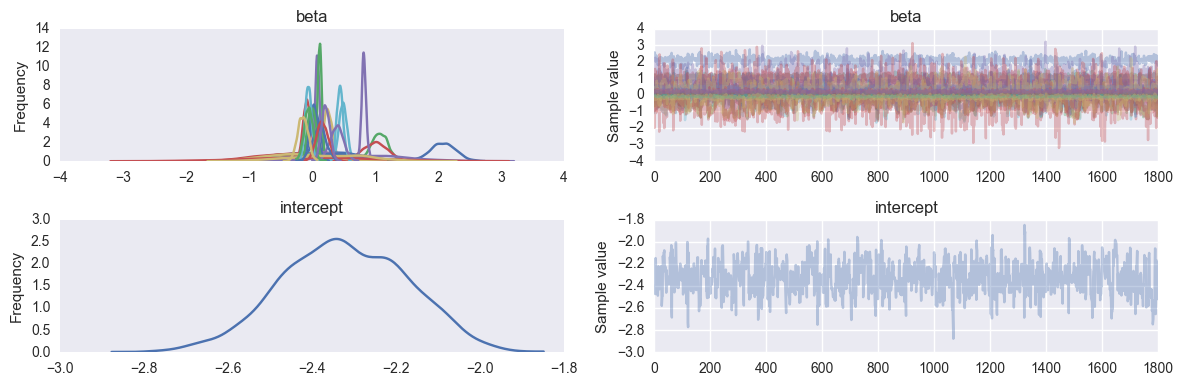

In [309]:
_ = pm.traceplot(trace[200:])

In [310]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.drop('mortality_day30', axis=1).columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

age  age_over_90    gender       bmi  bmi_missing  mech_vent  \
0  2.480281     1.059491 -0.083934  0.029931     0.102538   0.506543   
1  2.480900     1.183167 -0.162817  0.063618     0.339955   0.379694   
2  2.561863     1.240453 -0.156787  0.103796     0.306913   0.327378   
3  2.423545     1.200060 -0.109904  0.069143     0.334318   0.432319   
4  2.189449     0.980274  0.005217  0.069320     0.232777   0.619586   

        CHF      mdrd  creatinine_missing    apsiii    ...         nsicu  \
0  0.021157  0.121632            0.783267  0.751884    ...     -0.834670   
1 -0.075084  0.135706            0.929133  0.836697    ...     -0.754026   
2 -0.118412  0.164699            0.806155  0.864687    ...     -1.983810   
3  0.142364  0.114523            1.232171  0.802893    ...      1.570650   
4 -0.087600  0.112334            0.915410  0.895978    ...     -0.386481   

       micu  had_echo  fluid_day1  fluid_day1_missing  fluid_day2  \
0  0.494920 -0.016273   -0.029227            0.304557    0.041079   
1  0.426586  0.450361   -0.036891            0.304822    0.001060   
2  0.417312  0.416092   -0.016848            0.310720    0.021014   
3  0.409217  0.340846   -0.048005            0.083300   -0.022109   
4  0.458472  0.356554   -0.063760           -0.030136   -0.103213   

   fluid_day2_missing  fluid_day3  fluid_day3_missing  intercept  
0            0.286460    0.060255           -0.242168  -2.447667  
1            0.217862    0.092965           -0.153868  -2.436620  
2            0.275687    0.096872           -0.148958  -2.400709  
3            0.101356    0.211259           -0.313131  -2.401744  
4            0.157739    0.192377           -0.034477  -2.473976  

[5 rows x 36 columns]

In [311]:
sample_coefs.describe()

age  age_over_90       gender          bmi  bmi_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean      2.074800     1.067548    -0.082710     0.087926     0.253368   
std       0.202435     0.127985     0.058998     0.038599     0.071924   
min       1.437676     0.662573    -0.288080    -0.009149     0.016722   
25%       1.942688     0.980852    -0.123535     0.062211     0.205285   
50%       2.075382     1.070028    -0.081513     0.083779     0.250795   
75%       2.211590     1.159779    -0.041615     0.109659     0.301067   
max       2.741899     1.557041     0.129588     0.267467     0.484422   

         mech_vent          CHF         mdrd  creatinine_missing       apsiii  \
count  1800.000000  1800.000000  1800.000000         1800.000000  1800.000000   
mean      0.488027     0.051859     0.121061            0.992847     0.821571   
std       0.064240     0.069440     0.031446            0.197465     0.036874   
min       0.254096    -0.193745     0.015330            0.310130     0.679260   
25%       0.445577     0.004495     0.099560            0.857367     0.797843   
50%       0.488651     0.051330     0.121225            1.000521     0.820553   
75%       0.529809     0.100698     0.141719            1.130394     0.845319   
max       0.695321     0.278710     0.229527            1.710077     0.949641   

          ...             nsicu         micu     had_echo   fluid_day1  \
count     ...       1800.000000  1800.000000  1800.000000  1800.000000   
mean      ...          0.013135     0.391065     0.270210    -0.061065   
std       ...          1.005558     0.105788     0.618990     0.046527   
min       ...         -3.200195     0.008139    -1.661475    -0.247143   
25%       ...         -0.680657     0.320818    -0.158606    -0.093899   
50%       ...          0.005392     0.393685     0.302113    -0.061679   
75%       ...          0.694591     0.458299     0.742884    -0.028751   
max       ...          3.123474     0.731445     2.291908     0.102471   

       fluid_day1_missing   fluid_day2  fluid_day2_missing   fluid_day3  \
count         1800.000000  1800.000000         1800.000000  1800.000000   
mean             0.111270    -0.057252            0.161094     0.213345   
std              0.108010     0.068199            0.092757     0.065789   
min             -0.253131    -0.253106           -0.118392     0.002723   
25%              0.040124    -0.102525            0.099159     0.169524   
50%              0.115765    -0.056378            0.158831     0.211852   
75%              0.182615    -0.010227            0.223145     0.258322   
max              0.445917     0.179272            0.472081     0.452519   

       fluid_day3_missing    intercept  
count         1800.000000  1800.000000  
mean            -0.147865    -2.325204  
std              0.079523     0.148944  
min             -0.452536    -2.877318  
25%             -0.201466    -2.429804  
50%             -0.146298    -2.329630  
75%             -0.093019    -2.217671  
max              0.084128    -1.849013  

[8 rows x 36 columns]

In [312]:
W = sample_coefs.values[:,:X_mortality.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_mortality.values, W.T) + b
y_ppc = y_ppc.T
y_ppc.shape, y_mortality.shape

((1800, 7161), (7161,))

In [313]:
acc_ppc = (y_ppc > 0).astype(float) == y_mortality.values
acc_ppc = acc_ppc.mean(axis=1)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


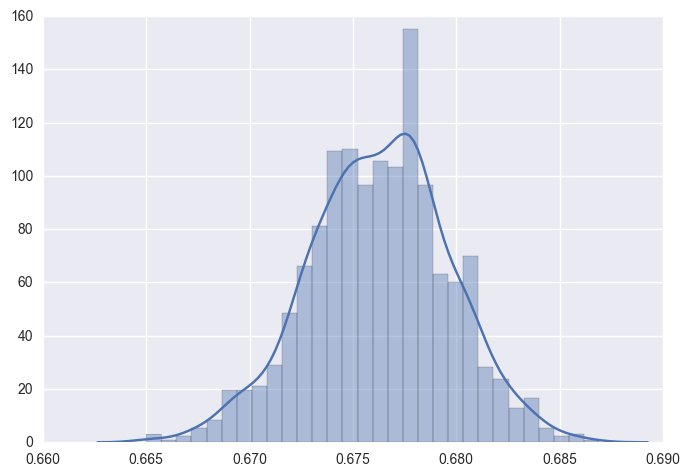

In [314]:
sns.distplot(acc_ppc)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


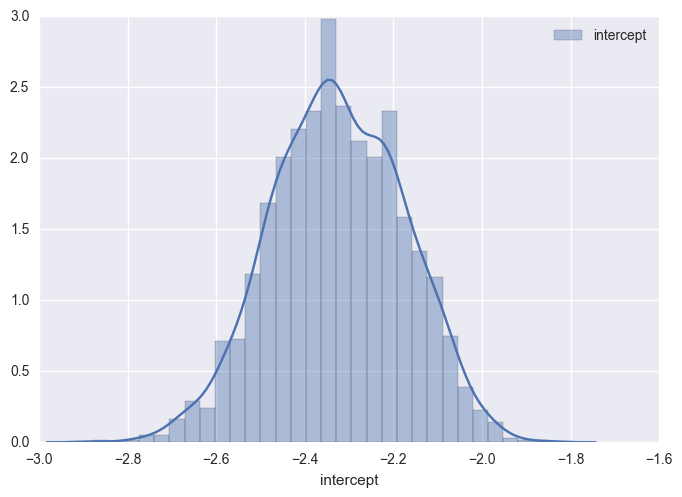

In [315]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

age  age_over_90       gender          bmi  bmi_missing
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000
mean      2.074800     1.067548    -0.082710     0.087926     0.253368
std       0.202435     0.127985     0.058998     0.038599     0.071924
min       1.437676     0.662573    -0.288080    -0.009149     0.016722
25%       1.942688     0.980852    -0.123535     0.062211     0.205285
50%       2.075382     1.070028    -0.081513     0.083779     0.250795
75%       2.211590     1.159779    -0.041615     0.109659     0.301067
max       2.741899     1.557041     0.129588     0.267467     0.484422

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


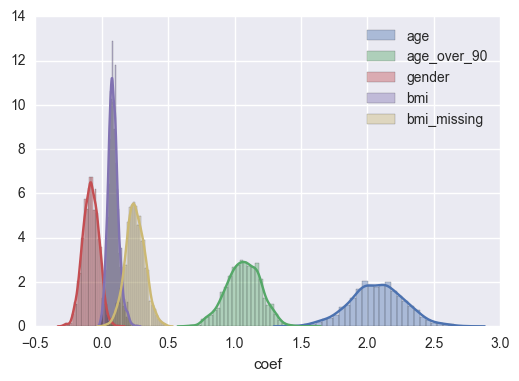

In [318]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_missing    lv_normal     lv_hyper      lv_mild  lv_moderate  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean      0.065732    -0.097651     0.348228    -0.039343    -0.211968   
std       0.415497     0.410179     0.420235     0.443543     0.443638   
min      -1.172276    -1.348256    -0.955867    -1.507855    -1.726928   
25%      -0.231019    -0.379073     0.049673    -0.334934    -0.534398   
50%       0.083907    -0.091613     0.349631    -0.031049    -0.209555   
75%       0.343626     0.183634     0.632144     0.253400     0.090365   
max       1.539707     1.271691     1.631507     1.405711     1.319074   

         lv_severe  
count  1800.000000  
mean      0.140485  
std       0.437703  
min      -1.439978  
25%      -0.148653  
50%       0.153796  
75%       0.433713  
max       1.868311

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


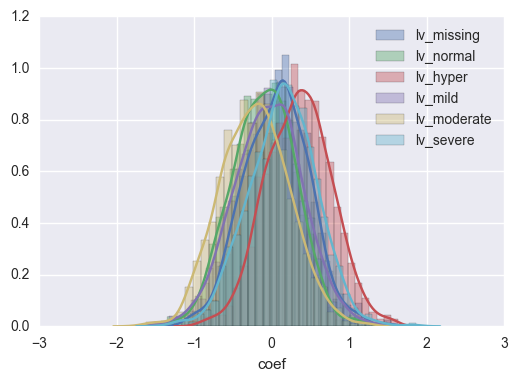

In [319]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

In [57]:
df.los.describe()

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    61522.000000
mean       117.533972
std        231.330963
min          0.000000
25%               NaN
50%               NaN
75%               NaN
max       4153.000000
Name: los, dtype: float64